Load modules.

In [1]:
import anndata
import operator
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import bbknn
import random
import scipy.stats
import scipy.io
import sys
import warnings
import seaborn as sns
% matplotlib inline
import os

warnings.filterwarnings('ignore')

In [2]:
def get_sample_number_dict(df):
    """
    Input:  A dataframe with samples.
    Output: Dictionary with dataframe annotations as keys and their respective sample counts as keys. 
    """

    cell_number_dict = {}
    for i in range(len(df.obs['annotation'].value_counts())):
        cell_number_dict[df.obs['annotation'].value_counts().index[i]] = df.obs['annotation'].value_counts().values[i]

    return cell_number_dict

In [3]:
def combine_input_files_to_dataframe(file1_path, file2_path, file3_path, file4_path):
    """
    Input:  Multiple matrix files to be combined.
    Output: Pandas dataframe.
    """

    # Read raw counts file to matrix.
    emtab7660_matrix = scipy.io.mmread(file1_path)

    # Read file with sample ids and store them in a list.
    columns_file = open(file2_path)
    sample_ids = columns_file.read().splitlines()

    # Read file with gene ensembl ids and store them in a list.
    rows_file = open(file3_path)
    gene_ensembl_ids = rows_file.read().splitlines()
    gene_ensembl_ids = [gene_ensembl_id.split("\t")[0] for gene_ensembl_id in gene_ensembl_ids]

    # Read  file with experimental design data.
    experimental_information_file = open(file4_path)
    # Get the sample characteristics stored for each sample in dataset and store them in a list. 
    # Example for sample characteristics : organism, strain, age, sampling site ...
    header = experimental_information_file.readline()
    list_sample_characteristics = [sample_characteristic for sample_characteristic in
                                   header.replace("\"", "").replace("\n", "").split("\t")]

    # For each sample characteristic store the values as a list in a dictionary.
    sample_characteristics_values_dict = {}
    experimental_information_tsv = pd.read_csv(file4_path, sep='\t')
    for sample_characteristic in list_sample_characteristics:
        sample_characteristics_values_dict[sample_characteristic] = experimental_information_tsv[
            sample_characteristic].tolist()

    matrix = emtab7660_matrix.todense()

    # Create a panda dataframe from counts matrix, sample_ids and gene_ensembl_ids.
    df = pd.DataFrame(matrix, index=gene_ensembl_ids, columns=sample_ids)
    result_df = sc.AnnData(df.transpose())

    # Add experimental design data to previously created dataframe.
    for sample_characteristic in list_sample_characteristics:
        result_df.obs[sample_characteristic] = sample_characteristics_values_dict[sample_characteristic]

    return result_df


In [4]:
def plot_pie_chart(annotat_count, title):
    """
    Input:  Dictionary with annotations as keys and their respective sample counts as values.
            String with pie chart title.
    Output: Pie chart with percentage of samples having each annotation.
    """

    labels = []
    sizes = []

    for label, size in annotat_count.items():
        labels.append(label)
        sizes.append(size)

    colours = {}
    i = 0
    for label in annotat_count.keys():
        col_code = 'C' + str(i)
        colours[label] = col_code
        i = i + 1

    fig, ax = plt.subplots(1, 1)
    ax.pie(sizes,
           labels=labels,
           colors=[colours[key] for key in labels], autopct='%1.0f%%')
    ax.set_title(title)

In [5]:
def get_mean_information(dataframe, list_of_annotations, hormone_gene_id='SCT'):
    """
    Input:  A dataframe with samples.
            List of annotations  in dataframe to show the mean hormone expression for.
    Output: Dictionary with annotations as keys and their respective mean SCT expression as value.
    """

    mean_expression_by_annotation = {}
    std_expression_by_annotation = {}
    local_min_expression_by_annotation = {}
    local_max_expression_by_annotation = {}
    list_of_annotations = list(dataframe.obs['annotation'].value_counts().index)
    # Output: ['Enterocyte', 'Proximal progenitor', 'TA', 'Stem cells', 'Goblet cell',
    #'Paneth', 'BEST4+ epithelial', 'Distal progenitor', 'EC cells (TAC1+)', 'EECs',
    #'Microfold cell', 'M/X cells (MLN/GHRL+)', 'Progenitor (NEUROG3+)', 'Tuft', 'CLDN10+ cells',
    #'I cells (CCK+)', 'Colonocyte', 'D cells (SST+)', 'K cells (GIP+)', 'L cells (PYY+)', 'N cells (NTS+)',
    #'BESlow_eec+ Goblet cell', 'β cells (INS+)', 'EC cells (NPW+)']
    global_min = sys.maxsize
    global_max = sys.maxsize * -1
    for i in range(len(list_of_annotations)):

        s1 = dataframe[dataframe.obs['annotation'].isin([list_of_annotations[i]])]
        s2 = s1[:, s1.var_names.str.fullmatch(hormone_gene_id)]

        local_max = np.amax(s2.X)
        local_min = np.amin(s2.X)
        local_min_expression_by_annotation[list_of_annotations[i]] = local_min
        local_max_expression_by_annotation[list_of_annotations[i]] = local_max

        if local_max > global_max:
            global_max = local_max
        if local_min < global_min:
            global_min = local_min

        sct_expression_mean_for_annotation = np.mean(s2.X)
        sct_expression_std_for_annotation = np.var(s2.X)
        mean_expression_by_annotation[list_of_annotations[i]] = sct_expression_mean_for_annotation
        std_expression_by_annotation[list_of_annotations[i]] = sct_expression_std_for_annotation

    sorted_sample_SCTcounts = dict(reversed(sorted(mean_expression_by_annotation.items(), key=lambda item: item[1])))
    var_by_annotation = dict(std_expression_by_annotation)

    return [sorted_sample_SCTcounts, var_by_annotation, ]

In [6]:
def get_samples_number_dict(dataframe, list_annotations):
    """
    Input:  A dataframe with samples.
            List of annotations to get the number of samples for.
    Output: Dictrionary with annotations as keys and their respective sample counts as value.
    """

    samples_number_dict = {}

    for annot in list_annotations:
        samples_number_dict[annot] = [dataframe[dataframe.obs['annotation'].isin([annot])].n_obs,
                                      dataframe[dataframe.obs['annotation'].isin([annot])].n_obs]

    return samples_number_dict

In [7]:
def show_mean_information(dataframe, annotation_mean_expr_dict, mean_threshold, list_annotation, samples_number_dict,
                          hormone='SCT'):
    """
    Input:  A dataframe with samples.
            Dictionary with annotations as keys and their respective mean SCT expression as value.
    Output: Prints mean SCT expression for each annotation, the number of cells belonging to each annotation
            and the number of batches which these samples originate from.
    """
    mean_dict = annotation_mean_expr_dict[0]
    var_dict = annotation_mean_expr_dict[1]

    a = 'Annotation'
    #c = "#batches"
    d = 'Mean ' + hormone + ' expression'
    #e = "#samples " 
    #f = 'Variance'
    total_samples_above_theshold = 0
    total_samples_below_theshold = 0
    list_annot_above_threshold = []
    list_annot_below_threshold = []
    #print("""%(one)s \t\t %(two)s""" % {'one': a, 'two':d})
    print(f"\n{a : <20}{d: ^25}\n")
    for annot, mean in mean_dict.items():
        if annot not in list_annotation:
            continue
        if mean <= mean_threshold:
            number_samples = dataframe[dataframe.obs['annotation'].isin([annot])].n_obs
            total_samples_below_theshold += number_samples
            samples_number_dict[annot][1] -= number_samples
            number_batches = len(
                set(dataframe[dataframe.obs['annotation'].isin([annot])].obs['batch'].value_counts().index))
            number_samples = dataframe[dataframe.obs['annotation'].isin([annot])].n_obs
            variance_annot = var_dict.get(annot)
            if number_samples > 10:
                #print("""%(one)s \t\t %(two)d""" % {'one': annot, 'two':mean})
                print(f"{annot.strip() : <20}{'{0:+.5f}'.format(mean) : ^25}")
                list_annot_below_threshold.append(annot)
        else:
            number_batches = len(
                set(dataframe[dataframe.obs['annotation'].isin([annot])].obs['batch'].value_counts().index))
            number_samples = dataframe[dataframe.obs['annotation'].isin([annot])].n_obs
            variance_annot = var_dict.get(annot)
            if number_samples > 10:
                print(f"{annot : <20}{'{0:+.5f}'.format(mean) : ^25}")
                list_annot_above_threshold.append(annot)

    return [list_annot_above_threshold, list_annot_below_threshold]


In [8]:
def keep_samples_in_list(dataframe, samples_list):
    """
    Input:  A dataframe with samples.
            List of samples to include in dataframe.  
    Output: Dataframe including only the samples in the input list.
    """

    return dataframe[dataframe.obs_names.isin(samples_list)]

In [9]:
def plot_log_expression_for_hormone(dataframe, hormone_gene_id_list, top_annotations_list):
    """
    Input:  A dataframe with samples.
            List of hormone gene ids to be plotted for each annotations.
            List of annotations to be inspected.
    Output: A plot. Expression of multiple hormones in different enteroendocrine cell populations.
    """

    remove_map_annot = {'GIP': ['L cells (PYY+)', 'N cells (NTS+)', 'M/X cells (MLN/GHRL+)', 'EC cells (TAC1+)'],
                        'TAC1': ['K cells (GIP+)', 'I cells (CCK+)', 'M/X cells (MLN/GHRL+)', 'D cells (SST+)'],
                        'SST': ['L cells (PYY+)', 'EC cells (TAC1+)'], 'GHRL': ['N cells (NTS+)'],
                        'PYY': ['D cells (SST+)', 'EC cells (TAC1+)'], 'CCK': ['EC cells (TAC1+)']}

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(18, 24),
                                                                         gridspec_kw={'hspace': 0.25, 'wspace': 0.15})
    #axis_hormone_map = {'SCT': [ax1,'autumn'],'K cells (GIP+)': [ax2,'winter'],'I cells (CCK+)': [ax3,'spring'],'L cells (PYY+)': [ax4,'summer'], 'N cells (NTS+)': [ax5,'Wistia'], 'D cells (SST+)':[ax6,'cool'], 'EC cells (TAC1+)':[ax7,'gray']}
    ax8.set_axis_off()
    annot_color_map = {'K cells (GIP+)': 'autumn', 'I cells (CCK+)': 'PiYG', 'L cells (PYY+)': 'summer',
                       'N cells (NTS+)': 'Wistia', 'D cells (SST+)': 'tab10', 'EC cells (TAC1+)': 'gray'}
    hormone_axis_map = {'SCT': ax7, 'GIP': ax2, 'CCK': ax3, 'PYY': ax4, 'NTS': ax5, 'TAC1': ax6, 'SST': ax1}

    dict_of_dicts = {}
    for hormone in hormone_gene_id_list:
        print(1, hormone)
        dict_values = {}
        s1 = dataframe[:, dataframe.var_names.str.fullmatch(hormone)]
        annot_to_plot_for_hormones = top_annotations_list.copy()

        if hormone in remove_map_annot.keys():
            annot_to_plot_for_hormones = list(set(annot_to_plot_for_hormones) ^ set(remove_map_annot.get(hormone)))

        for annotation in annot_to_plot_for_hormones:
            s2 = s1[s1.obs['annotation'].isin([annotation])]
            str_list = str(s2.X).replace('[', '').replace('\' ', '\'').replace(']]', '').split(']\n')
            float_list = [float(i.strip()) for i in str_list]
            dict_values[annotation] = float_list
        dict_of_dicts[hormone] = dict_values

        dict_of_dfs = {}

        for key, value in dict_of_dicts.get(hormone).items():
            dict_of_dfs[key] = pd.DataFrame({key: value})
        print(dict_of_dfs.keys())
        ax = hormone_axis_map[hormone]

        for hor in dict_of_dfs.keys():
            if hor in top_annotations_list:
                color = annot_color_map[hor]
                dict_of_dfs[hor].plot.kde(ax=ax, colormap=color)
        ax.set_title("Log transformed expression for hormone " + hormone)

    plt.savefig('hormones_50.png')

In [10]:
def plot_log_expression_for_hormone2(dataframe, annot_hormone_dict, top_annotations_list):
    """
    Input:  A dataframe with samples.
            List of hormone gene ids to be plotted for each annotations.
            List of annotations to be inspected.
    Output: A plot. Expression of multiple hormones in different enteroendocrine cell populations.
    """

    remove_map_annot = {'GIP': ['L cells (PYY+)', 'N cells (NTS+)', 'M/X cells (MLN/GHRL+)', 'EC cells (TAC1+)'],
                        'TAC1': ['K cells (GIP+)', 'I cells (CCK+)', 'M/X cells (MLN/GHRL+)', 'D cells (SST+)'],
                        'SST': ['L cells (PYY+)'], 'GHRL': ['N cells (NTS+)'], 'PYY': ['D cells (SST+)']}

    if len(top_annotations_list) == 1:
        fig, (ax1, ax7) = plt.subplots(2, 1, figsize=(10, 17), gridspec_kw={'hspace': 0.3})
        axis_hormone_map = {'SCT': ax7, annot_hormone_dict[top_annotations_list[0]]: ax1}
    elif len(top_annotations_list) == 2:
        fig, (ax1, ax2, ax7) = plt.subplots(3, 1, figsize=(10, 17), gridspec_kw={'hspace': 0.3})
        axis_hormone_map = {'SCT': ax7,
                            annot_hormone_dict[top_annotations_list[0]]: ax1,
                            annot_hormone_dict[top_annotations_list[1]]: ax2}
    elif len(top_annotations_list) == 3:
        fig, (ax1, ax2, ax3, ax7) = plt.subplots(4, 1, figsize=(10, 17), gridspec_kw={'hspace': 0.3})
        axis_hormone_map = {'SCT': ax7,
                            annot_hormone_dict[top_annotations_list[0]]: ax1,
                            annot_hormone_dict[top_annotations_list[1]]: ax2,
                            annot_hormone_dict[top_annotations_list[2]]: ax3}
    elif len(top_annotations_list) == 4:
        fig, (ax1, ax2, ax3, ax4, ax7) = plt.subplots(5, 1, figsize=(10, 17), gridspec_kw={'hspace': 0.3})
        axis_hormone_map = {'SCT': ax7,
                            annot_hormone_dict[top_annotations_list[0]]: ax1,
                            annot_hormone_dict[top_annotations_list[1]]: ax2,
                            annot_hormone_dict[top_annotations_list[2]]: ax3,
                            annot_hormone_dict[top_annotations_list[3]]: ax4}
    elif len(top_annotations_list) == 5:
        fig, (ax1, ax2, ax3, ax4, ax5, ax7) = plt.subplots(6, 1, figsize=(10, 17), gridspec_kw={'hspace': 0.3})
        axis_hormone_map = {'SCT': ax7,
                            annot_hormone_dict[top_annotations_list[0]]: ax1,
                            annot_hormone_dict[top_annotations_list[1]]: ax2,
                            annot_hormone_dict[top_annotations_list[2]]: ax3,
                            annot_hormone_dict[top_annotations_list[3]]: ax4,
                            annot_hormone_dict[top_annotations_list[4]]: ax5}
    elif len(top_annotations_list) == 6:
        fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize=(10, 17), gridspec_kw={'hspace': 0.3})
        axis_hormone_map = {'SCT': ax7,
                            annot_hormone_dict[top_annotations_list[0]]: ax1,
                            annot_hormone_dict[top_annotations_list[1]]: ax2,
                            annot_hormone_dict[top_annotations_list[2]]: ax3,
                            annot_hormone_dict[top_annotations_list[3]]: ax4,
                            annot_hormone_dict[top_annotations_list[4]]: ax5,
                            annot_hormone_dict[top_annotations_list[5]]: ax6}
    else:
        return "Something's wrong with the internet"

    #fig, (ax1, ax2, ax3, ax4,ax5,ax6) = plt.subplots(6, 1,figsize=(10,17),gridspec_kw={'hspace':0.3})                                                           
    #axis_hormone_map = {'SCT': ax7,'GIP': ax2,'CCK': ax3,'PYY': ax4, 'NTS': ax5, 'SST':ax6}

    dict_of_dicts = {}
    for hormone in hormone_gene_id_list:
        print(1, hormone)
        dict_values = {}
        s1 = dataframe[:, dataframe.var_names.str.fullmatch(hormone)]
        annot_to_plot_for_hormones = top_annotations_list.copy()

        if hormone in remove_map_annot.keys():
            annot_to_plot_for_hormones = list(set(annot_to_plot_for_hormones) ^ set(remove_map_annot.get(hormone)))

        for annotation in annot_to_plot_for_hormones:
            s2 = s1[s1.obs['annotation'].isin([annotation])]
            str_list = str(s2.X).replace('[', '').replace('\' ', '\'').replace(']]', '').split(']\n')
            float_list = [float(i.strip()) for i in str_list]
            dict_values[annotation] = float_list
        dict_of_dicts[hormone] = dict_values

        dict_of_dfs = {}

        for key, value in dict_of_dicts.get(hormone).items():
            dict_of_dfs[key] = pd.DataFrame({key: value})
        print(dict_of_dfs.keys())
        ax = axis_hormone_map[hormone]
        for hor in dict_of_dfs.keys():
            if hor in top_annotations_list:
                dict_of_dfs[hor].plot.kde(ax=ax)
        ax.set_title("Log transformed expression for hormone " + hormone)

    plt.savefig('hormones_50.png')

In [11]:
def plot_log_transformed_hormone_expression_for_sample_type(dataframe, hormone_gene_id_list, top_annotations_list):
    """
    Input:  A dataframe with samples.
            List of annotations and hormone gene ids to be inspected.
    Output: A plot. Expression of single hormones by different enteroendocrine cell populations
    """

    remove_map = {'N cells (NTS+)': ['GIP', 'GHRL'], 'K cells (GIP+)': ['TAC1'], 'I cells (CCK+)': ['TAC1'],
                  'M/X cells (MLN/GHRL+)': ['TAC1', 'GIP'], 'D cells (SST+)': ['TAC1', 'PYY'],
                  'L cells (PYY+)': ['GIP', 'SST'], 'EC cells (TAC1+)': ['GIP', 'CCK']}
    #remove_map = {}

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(18, 22),
                                                             gridspec_kw={'hspace': 0.15, 'wspace': 0.15})

    axis_map = {'K cells (GIP+)': ax1, 'I cells (CCK+)': ax2, 'L cells (PYY+)': ax3,
                'N cells (NTS+)': ax4, 'D cells (SST+)': ax5, 'EC cells (TAC1+)': ax6}

    hormone_color_map = {'SCT': 'spring', 'GIP': 'autumn', 'CCK': 'PiYG', 'PYY': 'summer', 'NTS': 'Wistia',
                         'SST': 'tab10', 'TAC1': 'gray'}

    for annotation in top_annotations_list:
        #print("\n"+ annotation)
        b = ''
        print(f"\n{b : <12}{annotation: ^12}\n")

        dict_values = {}
        s1 = dataframe[dataframe.obs['annotation'].isin([annotation])]
        hormones_to_plot_for_annot = hormone_gene_id_list.copy()
        if annotation in remove_map.keys():
            hormones_to_plot_for_annot = list(set(hormones_to_plot_for_annot) - set(remove_map.get(annotation)))
            #hormones_to_plot_for_annot.remove(remove_map.get(annotation))

        for hormone in hormones_to_plot_for_annot:
            s2 = s1[:, s1.var_names.str.fullmatch(hormone)]
            str_list = str(s2.X).replace('[', '').replace('\' ', '\'').replace(']]', '').split(']\n')
            float_list = [float(i.strip()) for i in str_list]
            dict_values[hormone] = float_list

        dict_of_dfs = {}
        for hormone, expression in dict_values.items():
            dict_of_dfs[hormone] = pd.DataFrame({hormone: expression})

        ax = axis_map[annotation]

        hormone_expression_dict = {}

        for hormone in dict_of_dfs.keys():
            dict_of_dfs[hormone].plot.kde(ax=ax, colormap=hormone_color_map[hormone])

            hormone_expression_dict[hormone] = np.mean(dict_of_dfs[hormone].values)

        sorted_dict_values = dict(reversed(sorted(hormone_expression_dict.items(), key=lambda item: item[1])))

        for key, value in sorted_dict_values.items():
            #print(key, value)
            print(f"{key : <12}{'{0:+.5f}'.format(value) : ^15}\n")

        axis_map[annotation].set_title("Log transformed hormone expression for " + annotation)

    plt.savefig('annotations_50.png')

In [12]:
def set_mitochondrial_genes_not_HighlyVariable(dataframe, mitochondrial_genes_list):
    """
    Input:  A dataframe with samples.
    Output: Void. For mitochondrial genes in dataset, the HighlyVariable gene feature is set to False.
    """

    mitochondrial_highly_variable = [x for x in dataframe.var_names if x in mitochondrial_genes_list]
    #print('The mitochondrial genes that were identified as being highly variable genes: \n', mitochondrial_highly_variable)
    for mit_gene in mitochondrial_highly_variable:
        dataframe[:, mit_gene].var.highly_variable[0] = False

    # Check that all mitochondrial genes were set to not highly variable.
    print('All mitochondrial genes were set to not highly variable: ',
          all([dataframe[:, mit_gene].var.highly_variable[0] == False for mit_gene in mitochondrial_highly_variable]))

In [13]:
def keep_annotations_in_list(dataframe, annotations_list):
    """
    Input:  A dataframe with samples.
            List of annotations to include in dataframe.  
    Output: Dataframe including only the annotations in the input list.
    """

    dataframe = dataframe[dataframe.obs['annotation'].isin(annotations_list)].copy()
    return dataframe

In [14]:
def get_mitochondrial_genes_list(anndata, use_server):
    """
    Input: A dataframe with samples.
           use_server boolean to specify which database of mitochondrial genes to use.  
    Output: List of mitochondrial genes present in database.
    """

    if use_server:
        # Use ensembl.org to get a list of human mitochondrial gene ids.
        mito_gene_ids = sc.queries.mitochondrial_genes(host="useast.ensembl.org", org="hsapiens")
    else:
        mito_gene_ids = [i for i in anndata.var_names if i.startswith("MT-")]
        #mito_gene_ids = ['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']

    #print("The following mitochondrial genes are expressed in the dataset: \n", mito_gene_ids)
    return mito_gene_ids

In [15]:
def filter_cells_by_region_category(anndata, region, category):
    """
    Input:  A dataframe with samples.
            String of region to be selected.
            String of category to be selected.
    Output: Subset of the input dataframe having the desired region and category.
    """

    anndata_subset = anndata[anndata.obs['Region'].isin([region])]
    anndata_subset = anndata_subset[anndata_subset.obs['category'].isin([category])]

    return anndata_subset

In [16]:
def check_if_NaN_values_present(dataframe):
    """
    Input:  A dataframe with samples.
    Output: True if ANY dataframe value is NaN.
    """

    return (dataframe.isna().any().any() or dataframe.isnull().values.any())

In [17]:
def check_numeric(dataframe):
    """
    Input: A dataframe with samples.
    Output: True if ALL dataframe values are numerical.
    """

    return dataframe.equals(dataframe.select_dtypes(include=np.number))

In [18]:
def check_dataframe_values(dataframe):
    """
    Input: A dataframe with samples.
    Output: True if dataframe does not include NaN values and all values are numerical.
    """

    if check_numeric(dataframe) and not check_if_NaN_values_present(dataframe):
        print("Dataframe does not include NaN values and all included values are numerical.")

In [19]:
def show_dataframe_samples_number(dataframe):
    """
    Input: A dataframe with samples.
    Output: Prints the number of cells in dataframe belonging to each annotation.
    """

    print("Number of current cells in dataset: ", dataframe.n_obs)
    print(dataframe.obs['annotation'].value_counts(), end="\n")

In [20]:
def show_dataframe_eec_samples_number(dataframe, top_annotations_list):
    """
    Input: A dataframe with samples.
    Output: Prints the number of enteroendocrine samples in dataframe belonging to each annotation.
    """

    eec_df = dataframe[dataframe.obs['annotation'].isin(top_annotations_list)]
    print("Number of current enteroendocrine samples in dataset: ", eec_df.n_obs)
    print(eec_df.obs['annotation'].value_counts(), end="\n")

In [21]:
def filter_sample_by_parameters(dataframe, mit_percentage_filter, n_genes_by_counts_filter, total_counts_filter,
                                print_info=True):
    """
    Input:  A dataframe with samples.
            Parameters with threshold values for %mitochondrial genes, n_genes_by_counts_filter, total_counts_filter.
    Output: Dataframe with samples filtered by the parameters.
    """
    number_samples = dataframe.n_obs

    dataframe = dataframe[dataframe.obs.pct_counts_mt < mit_percentage_filter]
    dataframe = dataframe[dataframe.obs.n_genes_by_counts < n_genes_by_counts_filter]
    dataframe = dataframe[dataframe.obs.total_counts < total_counts_filter]

    if print_info:
        print("Number of cells in dataset before filtering: ", number_samples)
        print("Number of cells in dataset after filtering: ", dataframe.n_obs)

    return dataframe

In [22]:
def read_dgca_results(hormone_gene_id):
    """
    Input:  A string with a hormone gene id.
    Output: DGCA results for input hormone gene id.
    """

    if hormone_gene_id == 'SCT':
        return pd.read_csv("/Users/technodoc/Desktop/sct_DGCA.csv", index_col=0)
    elif hormone_gene_id == 'CCK':
        return pd.read_csv("/Users/technodoc/Desktop/cck_DGCA.csv", index_col=0)
    elif hormone_gene_id == 'NTS':
        return pd.read_csv("/Users/technodoc/Desktop/nts_DGCA.csv", index_col=0)
    elif hormone_gene_id == 'PYY':
        return pd.read_csv("/Users/technodoc/Desktop/pyy_DGCA.csv", index_col=0)
    elif hormone_gene_id == 'GIP':
        return pd.read_csv("/Users/technodoc/Desktop/gip_DGCA.csv", index_col=0)

In [23]:
def get_top_correlations(dgca_results, sign, number=None):
    """
    Input:  DGCA analysis results.
            String '+' for positive corrleation.
            Number of top correlated gene ids.
    Output: Top correlated gene ids with desired corrleation sign and number of pairs.
    """

    if sign == '+':
        dgca_results = dgca_results[dgca_results.Classes.isin(["+/+", "+/0", "+/-"])]
    elif sign == '-':
        dgca_results = dgca_results[dgca_results.Classes.isin(["-/+", "-/0"])]

    if number is not None:
        dgca_results = dgca_results[:number]

    return dgca_results



In [24]:
def show_top_correlated_genes(top_correlations):
    """
    Input:  Pairs of correlated genes ids.
    Output: List of gene ids showing top correlation.
    """

    top_correlated_genes_list = top_correlations['Gene1'].values.tolist()
    print(top_correlated_genes_list)

    return top_correlated_genes_list

In [25]:
def plot_data_quality_information(orig_df, df, mit_percentage_filter, n_genes_by_counts_filter, total_counts_filter):
    """
    Input:  Dataframe with samples.
            Filter parameters for mitochondrial percentage, number of genes by counts and number of total counts.
    Output: Quality control plots for dataset.
    """

    min_total_counts = min(sc_data.obs['total_counts'].values)
    dataframe = df.copy()

    fig, ((ax1, ax2), (ax3, ax10)) = plt.subplots(2, 2, figsize=(17, 8), gridspec_kw={'wspace': 0.2})

    p1 = sc.pl.violin(orig_df, keys='pct_counts_mt', groupby='Region', rotation=0, ax=ax1, show=False)
    #p1.set_title("% mitochondrial genes vs diagnosis")
    p2 = sc.pl.violin(dataframe, keys='pct_counts_mt', groupby='Region code', rotation=0, ax=ax2, show=False)
    #p2.set_title("% mitochondrial genes vs region code of cell")
    p3 = sc.pl.violin(dataframe, keys='pct_counts_mt', groupby='Diagnosis', rotation=0, ax=ax3, show=False)
    p10 = sc.pl.violin(dataframe, keys='pct_counts_mt', groupby='Age_group', rotation=0, ax=ax10, show=False)
    #p3.set_title("% mitochondrial genes vs age group of cell donor")
    plt.savefig('QC_diagnosis_region_age.png')

    fig2, (ax7) = plt.subplots(1, 1, figsize=(10, 4), gridspec_kw={'wspace': 0.2})
    p9 = sc.pl.violin(dataframe, keys='pct_counts_mt', groupby='annotation', rotation=70, ax=ax7, show=False)
    #p9.set_title("% mitochondrial genes vs annotation")
    plt.savefig('QC_annotation.png')

    fig3, (ax4, ax6, ax5) = plt.subplots(1, 3, figsize=(20, 4), gridspec_kw={'wspace': 0.2})
    #fig3, (ax4, ax5) = plt.subplots(1, 2, figsize=(13,4), gridspec_kw={'wspace':0.3})

    #sc.pl.violin( dataframe, ['n_genes_by_counts','total_counts', 'pct_counts_mt'], multi_panel = True, xlabel='Dataset cells',ylabel='test')
    p4 = sc.pl.violin(dataframe, 'n_genes_by_counts', ylabel='samples', ax=ax4, show=False)
    #p4.set_title("Number of genes by counts")
    p5 = sc.pl.violin(dataframe, ['total_counts'], ylabel='samples', ax=ax5, show=False)
    #p5.set_title("Total numer of counts")
    #p6 = sc.pl.violin( dataframe, ['pct_counts_mt'], xlabel='Dataset cells',ylabel='pct_counts_mt', ax= ax6, show=False)
    p6 = sc.pl.scatter(dataframe, x='total_counts', y='n_genes_by_counts', ax=ax6, show=False)
    #p6.set_title("Percenteage of mitochondrial genes")
    plt.savefig('QC_covariatess.png')

    fig4, (ax7) = plt.subplots(1, 1, figsize=(10, 6))
    p7 = sc.pl.scatter(dataframe, x='total_counts', y='pct_counts_mt', ax=ax7, show=False, color='Age_group')
    ax7.add_patch(Rectangle((min_total_counts, 0), total_counts_filter - min_total_counts, mit_percentage_filter,
                            facecolor="none", ec='red', lw=1))
    plt.savefig('QC_overview1.png')
    #p7.set_title("Percentage of mitochondrial genes")

    #fig5, (ax8) = plt.subplots(1, 1, figsize=(10,6))
    #p8 = sc.pl.scatter(dataframe, x='total_counts', y='n_genes_by_counts',ax= ax8, show=False, color='Age_group')
    #ax8.add_patch(Rectangle((min_total_counts, 500), total_counts_filter-min_total_counts, n_genes_by_counts_filter-500, facecolor="none", ec ='red', lw = 1))
    #p8.set_title("Number of genes by counts")
    #plt.savefig('QC_overview22.png')

In [26]:
def plot_different_mit_pct_filter(dataframe, mit_percentage_filter, n_genes_by_counts_filter, total_counts_filter,
                                  top_annotations_list):
    """
    Input:  Dataframe with samples.
            Filter parameters for mitochondrial percentage, number of genes by counts and number of total counts.
            List of annotations of interest.
    Output: Plot showing dataset sample number dependence on the selected mitochondrial genes percentage threshold value.
    """
    allowed_mt_pct = [50, 40, 30, 20, 10]
    remaining_pct_eec_samples_after_filter = []
    remaining_pct_samples_after_filter = []

    enteroendocrine_cells = dataframe[dataframe.obs['annotation'].isin(top_annotations_list)]

    for mt_pct in allowed_mt_pct:
        remaining_pct_eec_samples_after_filter.append(filter_sample_by_parameters(enteroendocrine_cells,
                                                                                  mt_pct,
                                                                                  n_genes_by_counts_filter,
                                                                                  total_counts_filter,
                                                                                  False).n_obs)

    print("The number of enteroendocrine samples before filtering", remaining_pct_eec_samples_after_filter[0], "\n")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4), gridspec_kw={'wspace': 0.2})
    ax1.plot(allowed_mt_pct,
             remaining_pct_eec_samples_after_filter)
    ax1.set(xlabel="% mitochondrial genes",
            ylabel="# EEC samples")
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax1.invert_xaxis()
    ax1.grid(axis='x')

    for mt_pct in allowed_mt_pct:
        remaining_pct_samples_after_filter.append(filter_sample_by_parameters(dataframe,
                                                                              mt_pct,
                                                                              n_genes_by_counts_filter,
                                                                              total_counts_filter,
                                                                              False).n_obs)

    print("The number of enteroendocrine samples before filtering", remaining_pct_samples_after_filter[0])

    ax2.plot(allowed_mt_pct,
             remaining_pct_samples_after_filter)
    ax2.set(xlabel="% mitochondrial genes",
            ylabel="# samples")
    ax2.invert_xaxis()
    ax2.grid(axis='x')
    plt.savefig('Mit_dependence.png')
    plt.show()

In [27]:
def trajectory_analysis(copy_filtered_dataframe):
    """
    Input:  A dataframe with samples.
    Output: Trajectory analysis plots.
    """

    sc.pp.recipe_zheng17(copy_filtered_dataframe)
    sc.tl.pca(copy_filtered_dataframe, svd_solver='arpack')
    sc.pp.neighbors(copy_filtered_dataframe, n_neighbors=10, n_pcs=10)
    sc.tl.draw_graph(copy_filtered_dataframe)
    sc.pl.draw_graph(copy_filtered_dataframe, color='annotation', legend_loc='on data')
    sc.tl.louvain(copy_filtered_dataframe, resolution=1.0)
    #sc.tl.paga(copy_filtered_dataframe, groups='louvain')
    copy_filtered_dataframe.obs['louvain_anno'] = copy_filtered_dataframe.obs['louvain']
    copy_filtered_dataframe.obs['louvain_anno'].cat.categories = [str(index) for index in range(
        len(copy_filtered_dataframe.obs['louvain'].cat.categories))]
    sc.tl.paga(copy_filtered_dataframe, groups='louvain_anno')
    sc.pl.paga(copy_filtered_dataframe, threshold=0.03, show=False)
    sc.tl.draw_graph(copy_filtered_dataframe, init_pos='paga')
    sc.pl.draw_graph(copy_filtered_dataframe,
                     color=['louvain_anno', 'annotation', 'SCT', 'CCK', 'GIP', 'NTS', 'TAC1', 'NPW', 'CHGB', 'CHGA',
                            'NEUROD1', 'TFF3', 'FABP5', 'SPINK1', 'HOPX'], legend_loc='on data')

In [28]:
def get_copy_raw_data(dataframe):
    """
    Input:  A dataframe with samples.
    Output: Dataframe with raw count values of input datarame.
    """

    #Save the counts matrix as a layer, so we have a copy of the original count values, before applying data normalisation methods.
    #dataframe.layers["counts"] = dataframe.X.copy()
    dataframe_copy = dataframe.copy()

    return dataframe_copy

In [29]:
def downstream_analysis(dataframe, correct_mitochondrial, mitochondrial_genes_list, skip):
    """
    Downstream Analysis of all samples after filtering.
    """
    if not skip:
        #Visually inspect the filtering has been applied.
        #sc.pl.violin( dataframe, ['n_genes_by_counts','total_counts', 'pct_counts_mt'], multi_panel = True, save=True)

        # Store the raw count values as layer.
        dataframe.layers["counts"] = dataframe.X.copy()

        #Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization.
        sc.pp.normalize_total(dataframe, target_sum=1e4)

        #Logarithmize the data matrix.
        sc.pp.log1p(dataframe, base=2)

        #Identify highly-variable genes.
        sc.pp.highly_variable_genes(
            dataframe,
            n_top_genes=4000,
            # subset=True, # to automatically subset to the 4000 genes
            layer="counts",
            flavor="seurat_v3"
        )

        #Set the highly variable boolean to 'False' for mitochondrial genes.
        #This is done to remove the high mitochondrial gene expression bias identified in this dataset.
        if correct_mitochondrial:
            set_mitochondrial_genes_not_HighlyVariable(dataframe, mitochondrial_genes_list)

            #Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.
        dataframe.raw = dataframe

        #Filter the genes.
        dataframe = dataframe[:, dataframe.var.highly_variable].copy()

        #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed  using simple linear regression.
        sc.pp.regress_out(dataframe, ['total_counts', 'pct_counts_mt'])

        #Scale each gene to unit variance. Clip values exceeding standard deviation 10.
        sc.pp.scale(dataframe, max_value=10)

    #Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
    sc.tl.pca(dataframe)

    #Inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells in louvain or tSNE.
    #sc.pl.pca_variance_ratio(dataframe, log=True)

    #Compute the neighborhood graph of cells using the PCA representation of the data matrix. 
    sc.pp.neighbors(dataframe, n_pcs=10, n_neighbors=20)
    sc.tl.leiden(dataframe, resolution=0.4)

    #Use UMAP to embedd the graph in two dimensions.
    #sc.tl.umap(dataframe)
    #sc.pl.umap(dataframe, color=['batch','SCT','annotation','leiden'],use_raw=False, ncols = 1, hspace = 1, save=True)

    #Regressing out technical effect while including a biological grouping into the procedure helps mix batches better when used as input for BBKNN. We use the provide annotation as the biological grouping.
    bbknn.ridge_regression(dataframe, batch_key=['batch'], confounder_key=['annotation'])

    #Running BBKNN requires a dimensionality reduction (PCA by default).
    sc.pp.pca(dataframe)

    #Run BBKNN, which computes a batch balanced neighbourhood graph used as the basis for an UMAP.
    bbknn.bbknn(dataframe, batch_key='batch', neighbors_within_batch=1)

    #Plot UMAP using raw data. (normalized, logarithmized, uncorrected)
    #sc.tl.umap(dataframe)
    #sc.pl.umap(dataframe, color=['SCT','batch','annotation'], ncols = 2, hspace = 1, use_raw=True, color_map='Reds' )

    #Plot UMAP using raw data. (normalized, logarithmized, corrected)
    #sc.pl.umap(dataframe, color=['batch','SCT','annotation','leiden'], ncols = 1, hspace = 1, use_raw=False, color_map='Reds', save='2' )

    #Violin Plot of SCT expression according to cell annotation.
    #sc.pl.violin(dataframe, ['SCT'], groupby='annotation', use_raw=True, rotation=90)
    #sc.pl.violin(dataframe, ['SCT'], groupby='annotation', use_raw=False, rotation=90)

    return dataframe

In [30]:
def downstream_analysis2(dataframe, correct_mitochondrial, mitochondrial_genes_list, skip):
    """
    Downstream Analysis of all samples after filtering.
    """
    if not skip:
        #Visually inspect the filtering has been applied.
        #sc.pl.violin( dataframe, ['n_genes_by_counts','total_counts', 'pct_counts_mt'], multi_panel = True, save=True)

        # Store the raw count values as layer.
        dataframe.layers["counts"] = dataframe.X.copy()

        #Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization.
        sc.pp.normalize_total(dataframe, target_sum=1e4)

        #Logarithmize the data matrix.
        sc.pp.log1p(dataframe, base=2)

        #Identify highly-variable genes.
        sc.pp.highly_variable_genes(
            dataframe,
            n_top_genes=4000,
            # subset=True, # to automatically subset to the 4000 genes
            layer="counts",
            flavor="seurat_v3"
        )

        #Set the highly variable boolean to 'False' for mitochondrial genes.
        #This is done to remove the high mitochondrial gene expression bias identified in this dataset.
        if correct_mitochondrial:
            set_mitochondrial_genes_not_HighlyVariable(dataframe, mitochondrial_genes_list)

            #Plot highly-variable genes.
        sc.pl.highly_variable_genes(dataframe, log=True, save='highly_variable.png')

        #Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.
        dataframe.raw = dataframe

        #Filter the genes.
        dataframe = dataframe[:, dataframe.var.highly_variable].copy()

        #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed  using simple linear regression.
        sc.pp.regress_out(dataframe, ['total_counts', 'pct_counts_mt'])

        #Scale each gene to unit variance. Clip values exceeding standard deviation 10.
        sc.pp.scale(dataframe, max_value=10)

    #Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
    sc.tl.pca(dataframe)

    #Inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells in louvain or tSNE.
    #sc.pl.pca_variance_ratio(dataframe, log=True)

    #Compute the neighborhood graph of cells using the PCA representation of the data matrix. 
    sc.pp.neighbors(dataframe, n_pcs=10, n_neighbors=20)
    sc.tl.leiden(dataframe, resolution=0.7)

    #Use UMAP to embedd the graph in two dimensions.
    sc.tl.umap(dataframe)
    sc.pl.umap(dataframe, color=['batch', 'SCT', 'annotation', 'leiden'], use_raw=False, ncols=1, hspace=1, save=True)

    #Regressing out technical effect while including a biological grouping into the procedure helps mix batches better when used as input for BBKNN. We use the provide annotation as the biological grouping.
    bbknn.ridge_regression(dataframe, batch_key=['batch'], confounder_key=['annotation'])

    #Running BBKNN requires a dimensionality reduction (PCA by default).
    sc.pp.pca(dataframe)

    #Run BBKNN, which computes a batch balanced neighbourhood graph used as the basis for an UMAP.
    bbknn.bbknn(dataframe, batch_key='batch', neighbors_within_batch=1)

    #Plot UMAP using raw data. (normalized, logarithmized, uncorrected)
    sc.tl.umap(dataframe)
    #sc.pl.umap(dataframe, color=['SCT','batch','annotation'], ncols = 2, hspace = 1, use_raw=True, color_map='Reds' )

    #Plot UMAP using raw data. (normalized, logarithmized, corrected)
    sc.pl.umap(dataframe, color=['batch', 'SCT', 'annotation', 'leiden'], ncols=1, hspace=1, use_raw=False,
               color_map='Reds', save='2')

    #Violin Plot of SCT expression according to cell annotation.
    #sc.pl.violin(dataframe, ['SCT'], groupby='annotation', use_raw=True, rotation=90)
    sc.pl.violin(dataframe, ['SCT'], groupby='annotation', use_raw=False, rotation=90)

    return dataframe

In [31]:
def eec_downstream_analysis(dataframe, correct_mitochondrial, mitochondrial_genes_list):
    """
    Downstream Analysis of enterendocrine samples.
    """

    dataframe.layers["counts"] = dataframe.X.copy()

    #Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization.
    sc.pp.normalize_total(dataframe, target_sum=1e4)

    #Logarithmize the data matrix.
    sc.pp.log1p(dataframe, base=2)

    #Identify highly-variable genes.
    sc.pp.highly_variable_genes(
        dataframe,
        n_top_genes=4000,
        # subset=True, # to automatically subset to the 4000 genes
        layer="counts",
        flavor="seurat_v3"
    )

    #Set the highly variable boolean to 'False' for mitochondrial genes.
    #This is done to remove the high mitochondrial gene expression bias identified in this dataset.
    if correct_mitochondrial:
        set_mitochondrial_genes_not_HighlyVariable(dataframe, mitochondrial_genes_list)

        #Plot highly-variable genes.
    sc.pl.highly_variable_genes(dataframe, log=True)

    #Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.
    dataframe.raw = dataframe

    #Filter the genes.
    #dataframe = dataframe[:, dataframe.var.highly_variable].copy()

    #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed  using simple linear regression.
    sc.pp.regress_out(dataframe, ['total_counts', 'pct_counts_mt'])

    #Scale each gene to unit variance. Clip values exceeding standard deviation 10.
    sc.pp.scale(dataframe, max_value=10)

    #Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
    sc.tl.pca(dataframe)

    #Inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells in louvain or tSNE.
    sc.pl.pca_variance_ratio(dataframe, log=True)

    #Compute the neighborhood graph of cells using the PCA representation of the data matrix. 
    sc.pp.neighbors(dataframe, n_pcs=6, n_neighbors=12)

    sc.tl.leiden(dataframe, resolution=0.5)
    bbknn.ridge_regression(dataframe, batch_key=['batch'], confounder_key=['annotation'])
    sc.pp.pca(dataframe)
    bbknn.bbknn(dataframe, batch_key='batch', neighbors_within_batch=1)
    sc.tl.umap(dataframe)
    sc.pl.umap(dataframe, color=['annotation'], ncols=3, hspace=0.4, wspace=0.4, use_raw=False, palette="Set2",
               save='umap_eec_annot2.png')
    sc.pl.umap(dataframe, color=['SCT', 'CCK', 'GIP', 'NTS', 'PYY', 'TAC1'], ncols=2, hspace=0.2, wspace=0.1,
               use_raw=False, palette="Set2", save='umap_hormone2.png')
    sc.pl.umap(dataframe, color=['PCSK1N', 'CHGA', 'CHGB', 'PCSK1', 'SCT'], ncols=2, hspace=0.2, wspace=0.1,
               use_raw=False, palette="tab20", save='umap_hormone3.png', vmax=2, vmin=0)

    return dataframe

def get_hormone_expression_dict(hormone_list, df):
    """
    Input: A list with hormone gene ids as values.
    Output: A dictionary with hormone gene id as key and a list of expression values of all samples for that hormone as value.
    """
    
    hormone_expression_values = {}
    for hormone in hormone_list:
        s2 = df[:,df.var_names.str.fullmatch(hormone)]
        str_list = str((s2.X).tolist()).replace('[[','A').replace(']]','B').replace(']','').replace('[','').replace('A','').replace('B','').split(',')
        float_list =  [float(i.strip()) for i in str_list]
        hormone_expression_values[hormone] = float_list
    
    return hormone_expression_values
    
hor_expression_dict = get_hormone_expression_dict(hormone_gene_id_list, sc_data_subset)

In [32]:
def extract_expression_info(hormone_gene_id_list, sc_data_subset):
    """
    Input:   A dictionary with hormone gene id as key, and its ensembl id as value.
    Output:  Prints mean, std, min and max hormonal expression for each hormone in dictionary.
             Generates density plots of hormonal expression for each hormone in dictionary.
    """

    # Get dictionary with hormone gene id as key and a list of expression values of all samples for that hormone as value.
    hormone_expression_values = get_hormone_expression_dict(hormone_gene_id_list, sc_data_subset)

    # Store mean, std, min and max values for each hormone.
    mean_expression_by_hormone = {}
    std_expression_by_hormone = {}
    max_expression_for_hormone = {}
    min_expression_for_hormone = {}

    a = 'Hormone'
    b = 'Mean expression'
    c = "Std "
    d = "Min"
    e = "Max"

    print(f"{a : <10}{c: ^25}{d: ^20}{b: ^20}{e: ^20}\n")

    # Generate plots
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 12), gridspec_kw={'hspace': 0.3})

    # TODO: generate axis hormone map using hormone_id_dictionary
    axis_hormone_map = {'SCT': ax1, 'GIP': ax2, 'CCK': ax3, 'PYY': ax4, 'NTS': ax5, 'TAC1': ax6}

    for hor, values in hormone_expression_values.items():
        hormone_max = np.amax(values)
        hormone_min = np.amin(values)
        expression_mean_by_hormone = np.mean(values)
        expression_std_by_hormone = np.std(values)

        max_expression_for_hormone[hor] = hormone_max
        min_expression_for_hormone[hor] = hormone_min

        mean_expression_by_hormone[hor] = expression_mean_by_hormone
        std_expression_by_hormone[hor] = expression_std_by_hormone

        print(
            f"{hor : <10}{expression_std_by_hormone : ^25}{hormone_min : ^20}{expression_mean_by_hormone : ^20}{hormone_max : ^20}")

        values = pd.Series(values)
        ax = axis_hormone_map[hor]
        values.plot.kde(ax=ax)
        ax.set_title("Log transformed expression for hormone " + hor)

In [33]:
def show_interesting_annot_corr(list_annots, annot_corrDF_dict):
    data_frames = [value for key, value in annot_corrDF_dict.items() if key in list_annots]
    #print(data_frames)
    df_merged = pd.concat(data_frames, axis=1)
    return df_merged

In [34]:
def get_normalized_subsets_dict_for_annotations(dataframe, top_annotations_list):
    annotation_normal_subset_dict = {}

    for annotation in top_annotations_list:
        dataframe_subset = dataframe[dataframe.obs['annotation'].isin([annotation])]
        dataframe_subset = remove_genes_not_expressed(dataframe_subset, annotation)
        normalized_subset = norm_and_filter(dataframe_subset)
        annotation_normal_subset_dict[annotation] = normalized_subset

    return annotation_normal_subset_dict

In [35]:
def remove_genes_not_expressed(anndata, annotation=''):
    anndata_df = anndata.to_df()
    before = len(anndata_df.columns)
    anndata_df = anndata_df.loc[:, (anndata_df != 0).any(axis=0)]
    after = len(anndata_df.columns)
    print("Removing unexpressed genes for annotation:", annotation)
    print("#Genes before: ", before, "#Genes after: ", after, "\n")
    result = sc.AnnData(anndata_df)
    return result

In [36]:
def get_corr_for_hormone(annot_subset_dict, hormone_of_interest, threshold_corr=0):
    annot_corrDF_dict = {}

    for annotat, annot_subset in annotation_normal_subset_dict.items():
        key = hormone_of_interest + "_" + annotat
        top_eec_cor = annot_subset.to_df().corr()
        top_eec_sct = top_eec_cor[hormone_of_interest].to_frame()
        top_eec_test = top_eec_sct[(top_eec_sct[top_eec_sct.columns] >= threshold_corr).all(axis=1)]
        top_eec_test = top_eec_test.sort_values(by=hormone_of_interest, ascending=False)
        top_eec_test.rename(columns={hormone_of_interest: key}, inplace=True)
        annot_corrDF_dict[key] = top_eec_test

    return annot_corrDF_dict

In [37]:
def norm_and_filter(dataframe):
    #Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization.
    sc.pp.normalize_total(dataframe, target_sum=1e4)

    #Logarithmize the data matrix.
    sc.pp.log1p(dataframe, base=2)

    #Scale each gene to unit variance. Clip values exceeding standard deviation 10.
    sc.pp.scale(dataframe, max_value=10)

    return dataframe

In [38]:
def get_qc_info_for_parameters(orig_dataset, sc_data_subset, mit_percentage_filter, n_genes_by_counts_filter,
                               total_counts_filter, top_annotations_list):
    plot_data_quality_information(orig_dataset, sc_data_subset, mit_percentage_filter, n_genes_by_counts_filter,
                                  total_counts_filter)
    #Plot information of sample numbers for different mitochondrial filter parameter values.
    plot_different_mit_pct_filter(sc_data_subset, mit_percentage_filter, n_genes_by_counts_filter, total_counts_filter,
                                  top_annotations_list)

In [39]:
def remove_mitochondrial_genes(df, mitochondrial_genes_list):
    df = df[:, ~df.var_names.isin(mitochondrial_genes_list)].copy()
    return df

In [40]:
annot_hormone_dict = {
    'K cells (GIP+)': 'GIP',
    'I cells (CCK+)': 'CCK',
    'L cells (PYY+)': 'PYY',
    'N cells (NTS+)': 'NTS',
    'D cells (SST+)': 'SST',
    'EC cells (TAC1+)': 'TAC1'
}

Load input parameters for pipline.

In [41]:
# Annotations for cells types of interest.
#'M/X cells (MLN/GHRL+)' was removed from the list.
top_annotations_list = ['K cells (GIP+)', 'I cells (CCK+)', 'L cells (PYY+)', 'N cells (NTS+)', 'D cells (SST+)',
                        'EC cells (TAC1+)']

# Gene IDs for hormones of interest.
# TAC1, MLN was removed from the list.
hormone_gene_id_list = ['NTS', 'SST', 'GIP', 'CCK', 'PYY', 'TAC1', 'SCT']

# Threshold value for quality control parameters.
mit_percentage_filter = 20
total_counts_filter = 40000
n_genes_by_counts_filter = 5500

# Read h5ad file with raw count values.

Read the h5ad file with epithelial cells from the gut cell atlas project.

In [42]:
sc_data = sc.read_h5ad("/Users/technodoc/Downloads/epi_raw_counts02.h5ad")

Check no NaN values are present and all present values are numerical.

In [43]:
check_dataframe_values(sc_data.to_df())

Dataframe does not include NaN values and all included values are numerical.


# Filter dataset for cells originating from the small intestine and being epithelial cells.

Filter dataset to include only epithelial cells of the small intestine.

In [44]:
sc_data_subset = filter_cells_by_region_category(sc_data, 'SmallInt', 'Epithelial')

Show summary of samples in dataframe.

In [45]:
show_dataframe_samples_number(sc_data_subset)

Number of current cells in dataset:  73023
Enterocyte               36665
Proximal progenitor       9098
TA                        8267
Stem cells                6952
Goblet cell               4353
Paneth                    3017
BEST4+ epithelial         1176
Distal progenitor          492
EECs                       451
EC cells (TAC1+)           339
Progenitor (NEUROG3+)      315
Microfold cell             297
M/X cells (MLN/GHRL+)      293
CLDN10+ cells              256
Tuft                       242
I cells (CCK+)             226
Colonocyte                 218
D cells (SST+)             128
K cells (GIP+)              83
L cells (PYY+)              52
N cells (NTS+)              38
β cells (INS+)              31
BEST2+ Goblet cell          27
EC cells (NPW+)              7
Name: annotation, dtype: int64


In [46]:
sc_data_subset

View of AnnData object with n_obs × n_vars = 73023 × 33538
    obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Gender', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'annotation', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types'

Plot genes_by_counts, total_counts and pct_counts_mt.
Plot % mitochonfrial genes vs diagnosis, vs region code of cell, vs age group of cell donor.

# Quality control and filtering.

Plot information of sample numbers for different mitochondrial filter parameter values.

The number of enteroendocrine samples before filtering 828 

The number of enteroendocrine samples before filtering 68719


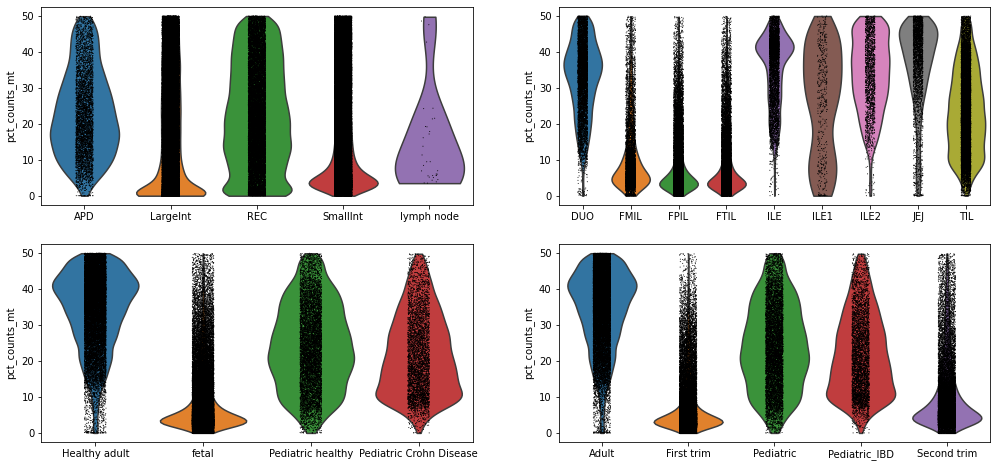

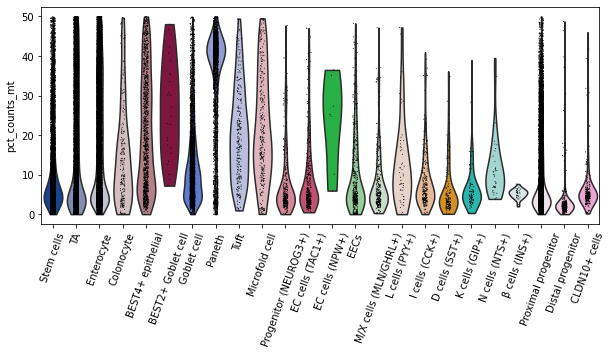

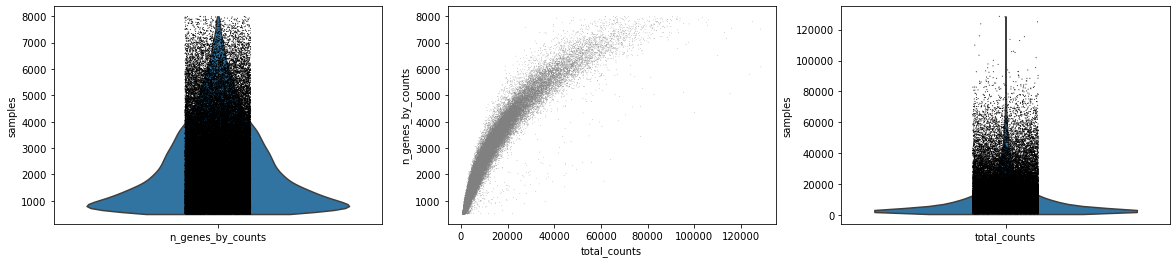

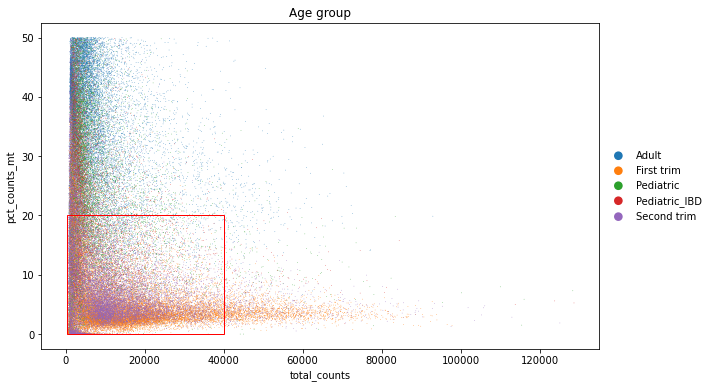

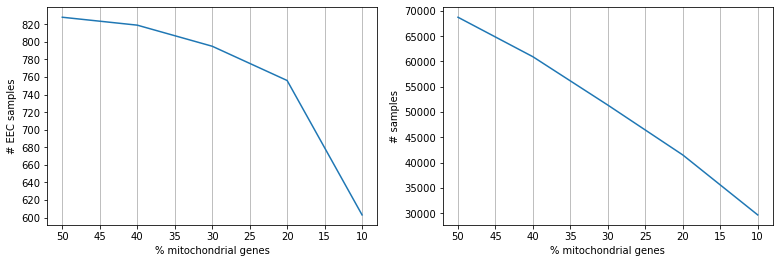

In [47]:
get_qc_info_for_parameters(sc_data, sc_data_subset, mit_percentage_filter, n_genes_by_counts_filter,
                           total_counts_filter, top_annotations_list)

Filter dataframe samples using input parameters.

In [48]:
sc_data_subset = filter_sample_by_parameters(sc_data_subset, mit_percentage_filter, n_genes_by_counts_filter,
                                             total_counts_filter, print_info=True).copy()

Number of cells in dataset before filtering:  73023
Number of cells in dataset after filtering:  41525


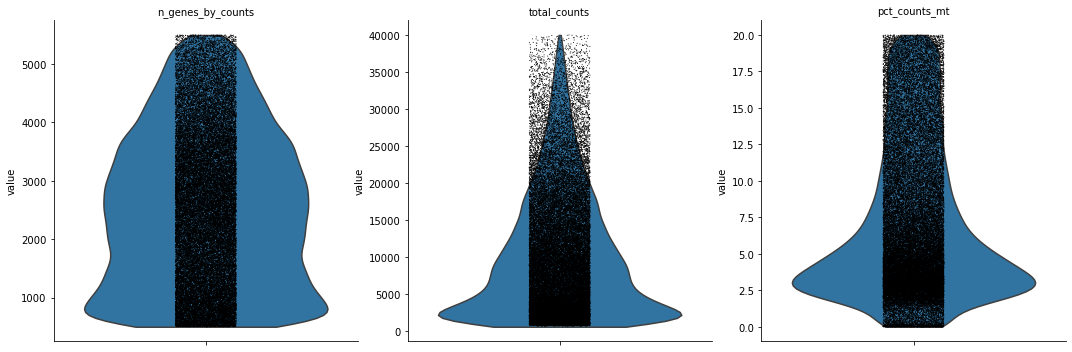

In [49]:
sc.pl.violin(sc_data_subset, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], multi_panel=True,
             save='after_filter.png')

Show summary of samples in dataframe after filtering.

In [50]:
show_dataframe_samples_number(sc_data_subset)

Number of current cells in dataset:  41525
Enterocyte               18948
Proximal progenitor       6387
Stem cells                4923
TA                        4307
Goblet cell               3263
BEST4+ epithelial          596
Distal progenitor          466
Paneth                     395
EC cells (TAC1+)           301
EECs                       297
Progenitor (NEUROG3+)      256
M/X cells (MLN/GHRL+)      248
CLDN10+ cells              222
I cells (CCK+)             187
Microfold cell             147
Colonocyte                 146
Tuft                       126
D cells (SST+)             115
K cells (GIP+)              77
L cells (PYY+)              42
N cells (NTS+)              34
β cells (INS+)              30
BEST2+ Goblet cell          10
EC cells (NPW+)              2
Name: annotation, dtype: int64


Show summary of enteroendocrine samples in dataframe after filtering.

In [51]:
#show_dataframe_eec_samples_number(sc_data_subset, top_annotations_list)

Save a copy of the current dataframe raw value counts to be used in different steps.

In [52]:
copy_filtered_dataframe = sc_data_subset.copy()
list_names = copy_filtered_dataframe.obs_names.to_list()

# Remove mitochondrial genes from dataframe.

Store mitochondrial gene ids present in dataframe.

In [53]:
mitochondrial_genes_list = get_mitochondrial_genes_list(sc_data_subset, False)

Remove mitochondrial genes from dataframe.

In [54]:
sc_data_subset = remove_mitochondrial_genes(sc_data_subset, mitochondrial_genes_list)

In [55]:
copy_dataset = sc_data_subset.copy()

# Downstream Analysis

In [56]:
eec_cells = sc_data_subset[sc_data_subset.obs['annotation'].isin(top_annotations_list)]

In [57]:
#sc_data_subset = eec_downstream_analysis(eec_cells, True, mitochondrial_genes_list)

sc_data_subset = downstream_analysis(sc_data_subset, True, mitochondrial_genes_list, False)
#sc_data_subset = norm_and_filter(sc_data_subset)

All mitochondrial genes were set to not highly variable:  True


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [58]:
#sc.pl.violin(sc_data_subset, ['SCT'], groupby='annotation', use_raw=True, rotation=80, save='raw.png')
#sc.pl.violin(sc_data_subset, ['SCT'], groupby='annotation', use_raw=False, rotation=80, save='log_unsorted.png')
#sc.pl.violin(sc_data_subset, ['NTS'], groupby='annotation', use_raw=False, rotation=80, save='nts_log_unsorted.png')
#sc.pl.violin(sc_data_subset, ['CCK'], groupby='annotation', use_raw=False, rotation=80, save='cck_log_unsorted.png')

# Print mean SCT expression for each dataframe annotation found in list.

In [59]:
samples_number_dict = get_samples_number_dict(sc_data_subset,
                                              list(sc_data_subset.obs['annotation'].value_counts().index))

#annotation_mean_SCT_expr_dict= get_mean_information(sc_data_subset, list(sc_data_subset.obs['annotation'].value_counts().index), hormone_gene_id_list)
#list_of_lists = show_mean_information(sc_data_subset, annotation_mean_SCT_expr_dict, 0.5, list(sc_data_subset.obs['annotation']), samples_number_dict, hormone_gene_id_list)

#samples_number_dict = get_samples_number_dict(sc_data_subset, list(sc_data_subset.obs['annotation'].value_counts().index))

hormone_dict = {}
for hormone_gene_id in hormone_gene_id_list:
    annotation_mean_SCT_expr_dict = get_mean_information(sc_data_subset,
                                                         list(sc_data_subset.obs['annotation'].value_counts().index),
                                                         hormone_gene_id)
    list_of_lists = show_mean_information(sc_data_subset, annotation_mean_SCT_expr_dict, 1, top_annotations_list,
                                          samples_number_dict, hormone_gene_id)
    hormone_dict[hormone_gene_id] = list_of_lists


Annotation             Mean NTS expression   

N cells (NTS+)              +9.71588         
I cells (CCK+)              +2.04028         
L cells (PYY+)              +0.84272         
EC cells (TAC1+)            +0.38872         
K cells (GIP+)              +0.23838         
D cells (SST+)              +0.04877         

Annotation             Mean SST expression   

D cells (SST+)              +9.06742         
K cells (GIP+)              +3.00430         
I cells (CCK+)              +0.29734         
N cells (NTS+)              -0.05204         
EC cells (TAC1+)            -0.07705         
L cells (PYY+)              -0.25477         

Annotation             Mean GIP expression   

K cells (GIP+)              +7.74337         
I cells (CCK+)              +0.61093         
EC cells (TAC1+)            -0.01786         
D cells (SST+)              -0.02287         
L cells (PYY+)              -0.12543         
N cells (NTS+)              -0.14598         

Annotation             Mean

In [60]:
l = hormone_dict['TAC1'][0] + hormone_dict['TAC1'][1]
print(l)

['N cells (NTS+)', 'EC cells (TAC1+)', 'L cells (PYY+)', 'I cells (CCK+)', 'K cells (GIP+)', 'D cells (SST+)']


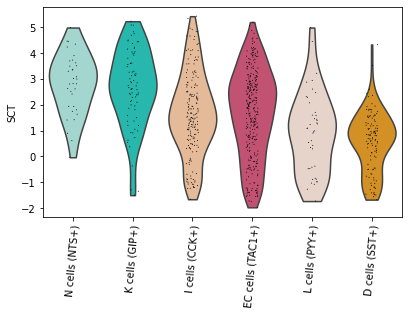

In [61]:
sc.pl.violin(sc_data_subset, ['SCT'], groupby='annotation', use_raw=False, rotation=85,
             order=['N cells (NTS+)', 'K cells (GIP+)', 'I cells (CCK+)', 'EC cells (TAC1+)', 'L cells (PYY+)',
                    'D cells (SST+)'], save='sct_log_sorted.png')

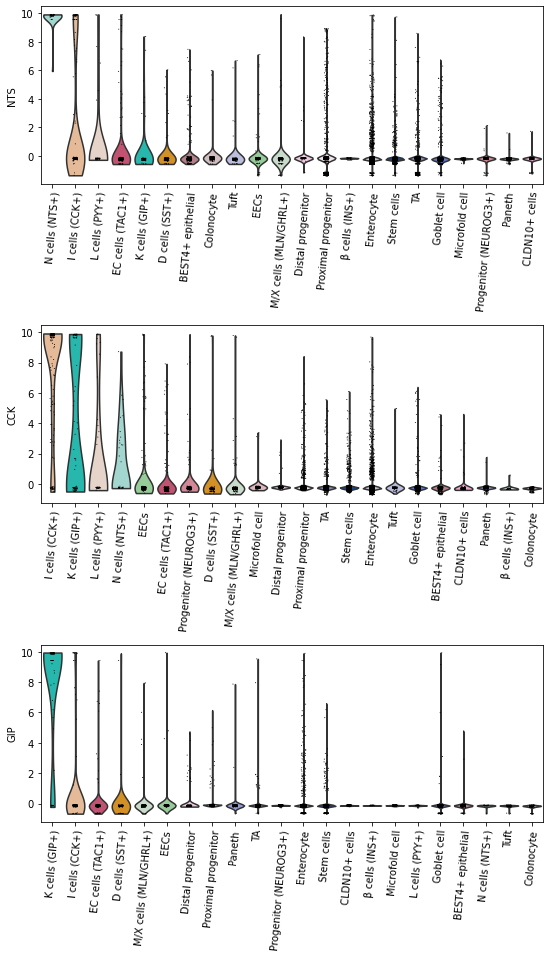

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 15), gridspec_kw={'hspace': 0.8})
p1 = sc.pl.violin(sc_data_subset, ['NTS'], groupby='annotation', show=False, use_raw=False, ax=ax1, rotation=85,
                  order=['N cells (NTS+)', 'I cells (CCK+)', 'L cells (PYY+)', 'EC cells (TAC1+)', 'K cells (GIP+)',
                         'D cells (SST+)', 'BEST4+ epithelial', 'Colonocyte', 'Tuft', 'EECs', 'M/X cells (MLN/GHRL+)',
                         'Distal progenitor', 'Proximal progenitor', 'β cells (INS+)', 'Enterocyte', 'Stem cells', 'TA',
                         'Goblet cell', 'Microfold cell', 'Progenitor (NEUROG3+)', 'Paneth', 'CLDN10+ cells'])

p2 = sc.pl.violin(sc_data_subset, ['CCK'], groupby='annotation', show=False, use_raw=False, ax=ax2, rotation=85,
                  order=['I cells (CCK+)', 'K cells (GIP+)', 'L cells (PYY+)', 'N cells (NTS+)', 'EECs',
                         'EC cells (TAC1+)', 'Progenitor (NEUROG3+)', 'D cells (SST+)', 'M/X cells (MLN/GHRL+)',
                         'Microfold cell', 'Distal progenitor', 'Proximal progenitor', 'TA', 'Stem cells', 'Enterocyte',
                         'Tuft', 'Goblet cell', 'BEST4+ epithelial', 'CLDN10+ cells', 'Paneth', 'β cells (INS+)',
                         'Colonocyte'])

p3 = sc.pl.violin(sc_data_subset, ['GIP'], groupby='annotation', show=False, use_raw=False, ax=ax3, rotation=85,
                  order=['K cells (GIP+)', 'I cells (CCK+)', 'EC cells (TAC1+)', 'D cells (SST+)',
                         'M/X cells (MLN/GHRL+)', 'EECs', 'Distal progenitor', 'Proximal progenitor', 'Paneth', 'TA',
                         'Progenitor (NEUROG3+)', 'Enterocyte', 'Stem cells', 'CLDN10+ cells', 'β cells (INS+)',
                         'Microfold cell', 'L cells (PYY+)', 'Goblet cell', 'BEST4+ epithelial', 'N cells (NTS+)',
                         'Tuft', 'Colonocyte'])
plt.savefig('EEC_expr_violin2.png')

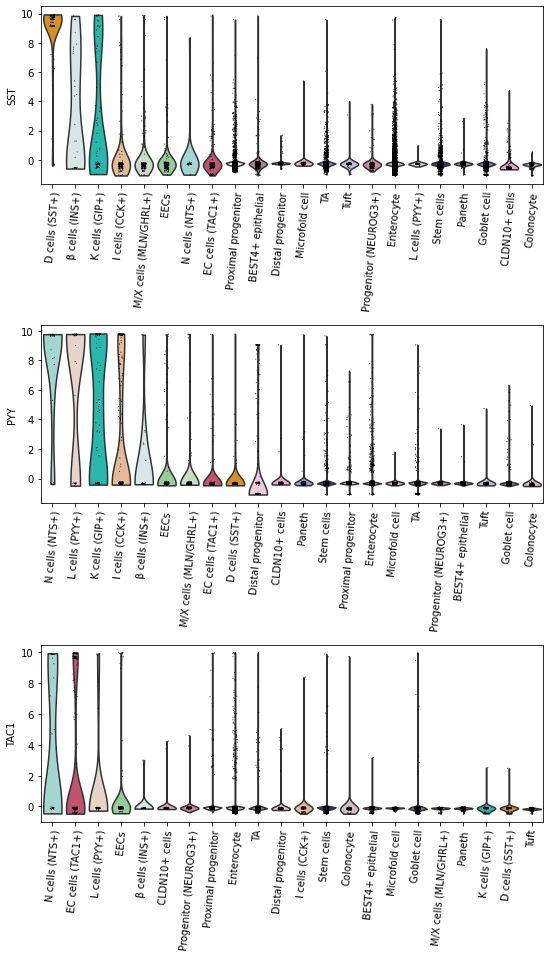

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 15), gridspec_kw={'hspace': 0.8})
p1 = sc.pl.violin(sc_data_subset, ['SST'], groupby='annotation', show=False, use_raw=False, ax=ax1, rotation=85,
                  order=['D cells (SST+)', 'β cells (INS+)', 'K cells (GIP+)', 'I cells (CCK+)',
                         'M/X cells (MLN/GHRL+)', 'EECs', 'N cells (NTS+)', 'EC cells (TAC1+)', 'Proximal progenitor',
                         'BEST4+ epithelial', 'Distal progenitor', 'Microfold cell', 'TA', 'Tuft',
                         'Progenitor (NEUROG3+)', 'Enterocyte', 'L cells (PYY+)', 'Stem cells', 'Paneth', 'Goblet cell',
                         'CLDN10+ cells', 'Colonocyte'])

p2 = sc.pl.violin(sc_data_subset, ['PYY'], groupby='annotation', show=False, use_raw=False, ax=ax2, rotation=85,
                  order=['N cells (NTS+)', 'L cells (PYY+)', 'K cells (GIP+)', 'I cells (CCK+)', 'β cells (INS+)',
                         'EECs', 'M/X cells (MLN/GHRL+)', 'EC cells (TAC1+)', 'D cells (SST+)', 'Distal progenitor',
                         'CLDN10+ cells', 'Paneth', 'Stem cells', 'Proximal progenitor', 'Enterocyte', 'Microfold cell',
                         'TA', 'Progenitor (NEUROG3+)', 'BEST4+ epithelial', 'Tuft', 'Goblet cell', 'Colonocyte'])

p3 = sc.pl.violin(sc_data_subset, ['TAC1'], groupby='annotation', show=False, use_raw=False, ax=ax3, rotation=85,
                  order=['N cells (NTS+)', 'EC cells (TAC1+)', 'L cells (PYY+)', 'EECs', 'β cells (INS+)',
                         'CLDN10+ cells', 'Progenitor (NEUROG3+)', 'Proximal progenitor', 'Enterocyte', 'TA',
                         'Distal progenitor', 'I cells (CCK+)', 'Stem cells', 'Colonocyte', 'BEST4+ epithelial',
                         'Microfold cell', 'Goblet cell', 'M/X cells (MLN/GHRL+)', 'Paneth', 'K cells (GIP+)',
                         'D cells (SST+)', 'Tuft'])
plt.savefig('EEC_expr_violin3.png')

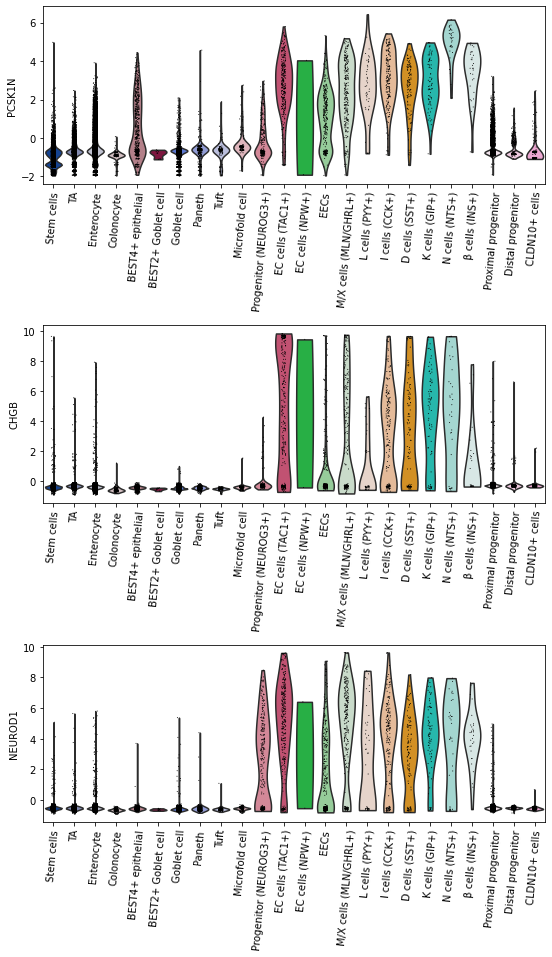

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 15), gridspec_kw={'hspace': 0.8})
p1 = sc.pl.violin(sc_data_subset, ['PCSK1N'], groupby='annotation', show=False, use_raw=False, ax=ax1, rotation=85)

p2 = sc.pl.violin(sc_data_subset, ['CHGB'], groupby='annotation', show=False, use_raw=False, ax=ax2, rotation=85)

p3 = sc.pl.violin(sc_data_subset, ['NEUROD1'], groupby='annotation', show=False, use_raw=False, ax=ax3, rotation=85)
plt.savefig('EEC_expr_violin3.png')

In [65]:
print(list_of_lists[0])

['N cells (NTS+)', 'K cells (GIP+)', 'EC cells (TAC1+)', 'I cells (CCK+)']



            K cells (GIP+)

GIP            +7.74337    

PYY            +4.54275    

CCK            +3.85512    

SST            +3.00430    

SCT            +2.65536    

NTS            +0.23838    


            I cells (CCK+)

CCK            +7.45393    

PYY            +2.74183    

NTS            +2.04028    

SCT            +1.64597    

GIP            +0.61093    

SST            +0.29734    


            L cells (PYY+)

PYY            +6.18063    

CCK            +1.74040    

TAC1           +0.94697    

SCT            +0.92631    

NTS            +0.84272    


            N cells (NTS+)

NTS            +9.71588    

PYY            +7.64171    

TAC1           +3.39755    

SCT            +2.80742    

CCK            +1.39054    

SST            -0.05204    


            D cells (SST+)

SST            +9.06742    

SCT            +0.57719    

NTS            +0.04877    

GIP            -0.02287    

CCK            -0.10746    


            EC cells (TAC1+)

TAC1        

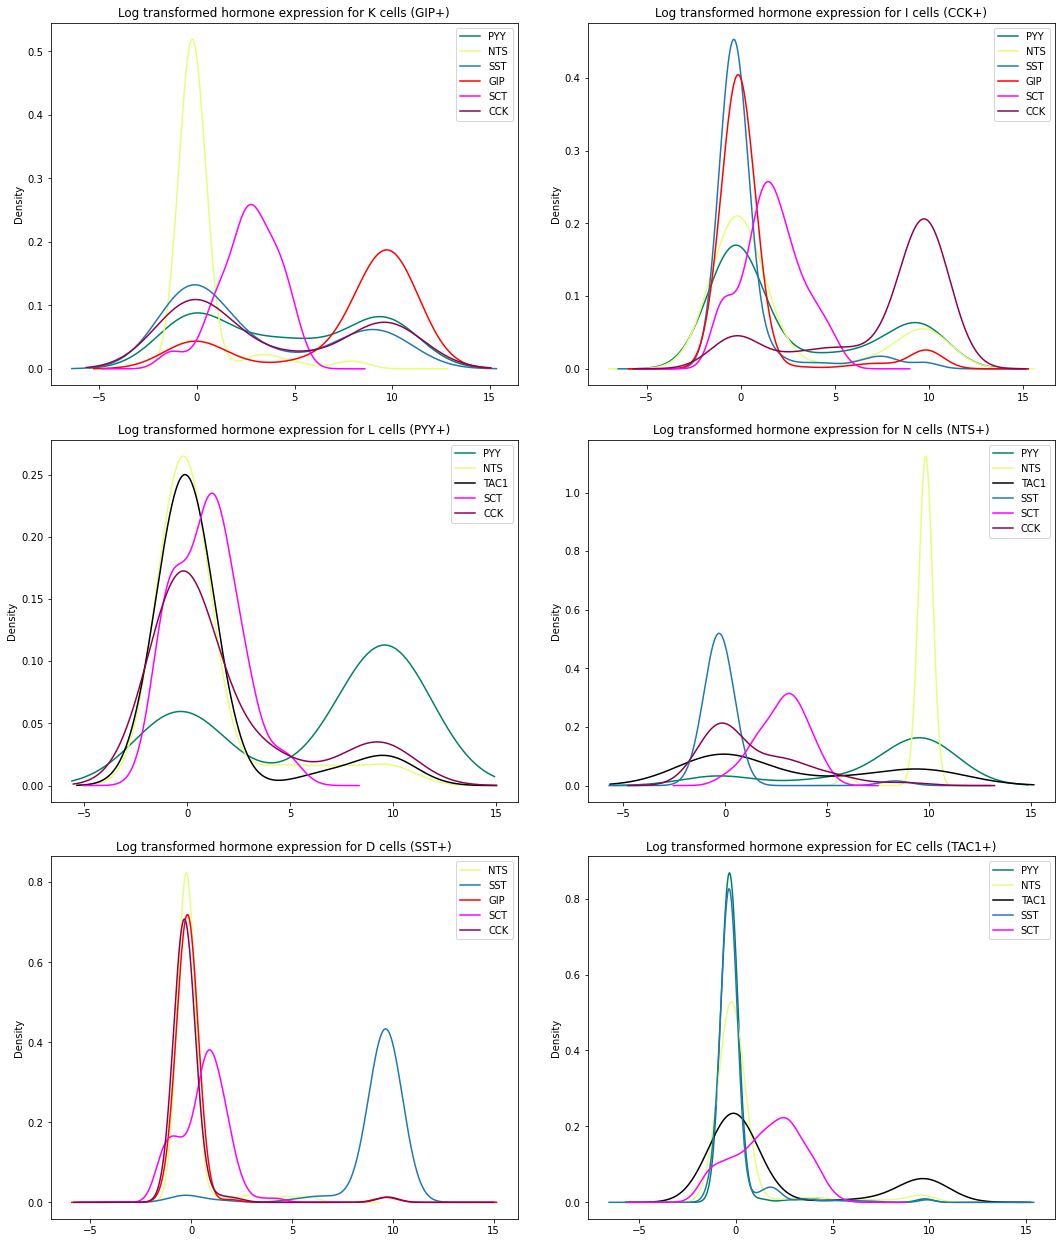

In [66]:
plot_log_transformed_hormone_expression_for_sample_type(sc_data_subset, hormone_gene_id_list, top_annotations_list)

# Expression of multiple hormones in different enteroendocrine cell populations.

1 NTS
dict_keys(['K cells (GIP+)', 'I cells (CCK+)', 'L cells (PYY+)', 'N cells (NTS+)', 'D cells (SST+)', 'EC cells (TAC1+)'])
1 SST
dict_keys(['I cells (CCK+)', 'N cells (NTS+)', 'D cells (SST+)', 'K cells (GIP+)'])
1 GIP
dict_keys(['I cells (CCK+)', 'D cells (SST+)', 'M/X cells (MLN/GHRL+)', 'K cells (GIP+)'])
1 CCK
dict_keys(['I cells (CCK+)', 'N cells (NTS+)', 'D cells (SST+)', 'L cells (PYY+)', 'K cells (GIP+)'])
1 PYY
dict_keys(['I cells (CCK+)', 'N cells (NTS+)', 'L cells (PYY+)', 'K cells (GIP+)'])
1 TAC1
dict_keys(['L cells (PYY+)', 'N cells (NTS+)', 'EC cells (TAC1+)', 'M/X cells (MLN/GHRL+)'])
1 SCT
dict_keys(['K cells (GIP+)', 'I cells (CCK+)', 'L cells (PYY+)', 'N cells (NTS+)', 'D cells (SST+)', 'EC cells (TAC1+)'])


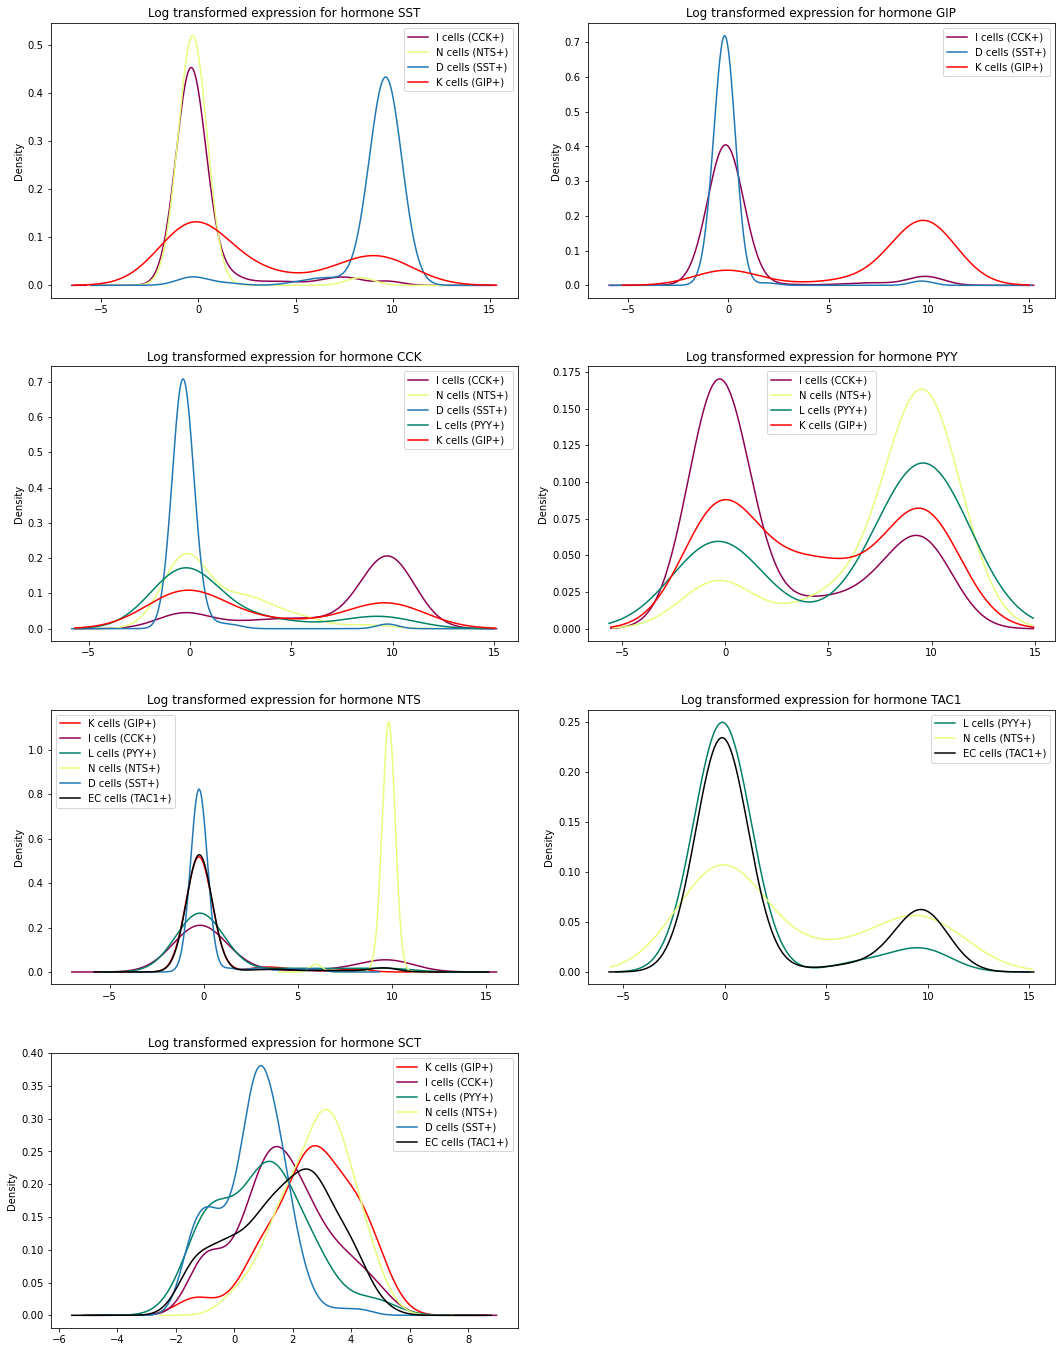

In [67]:
plot_log_expression_for_hormone(sc_data_subset, hormone_gene_id_list, top_annotations_list, )

# Expression of single hormones by different enteroendocrine cell populations

All mitochondrial genes were set to not highly variable:  True


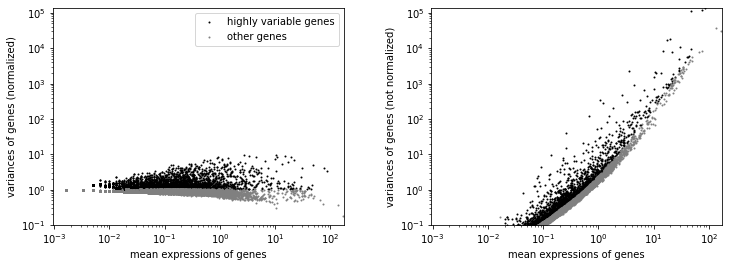

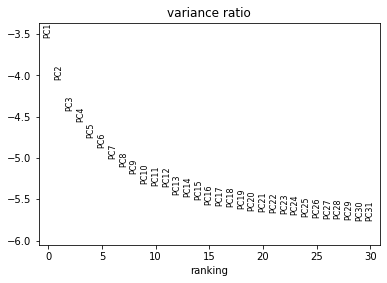

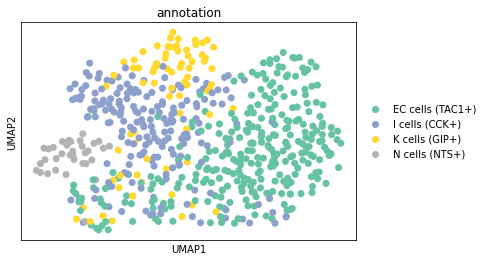

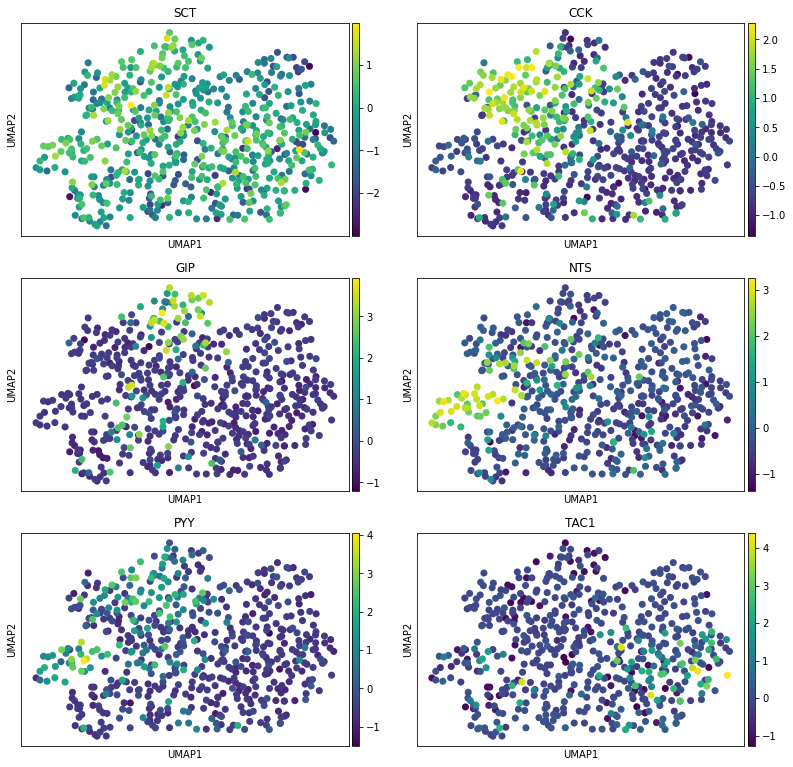

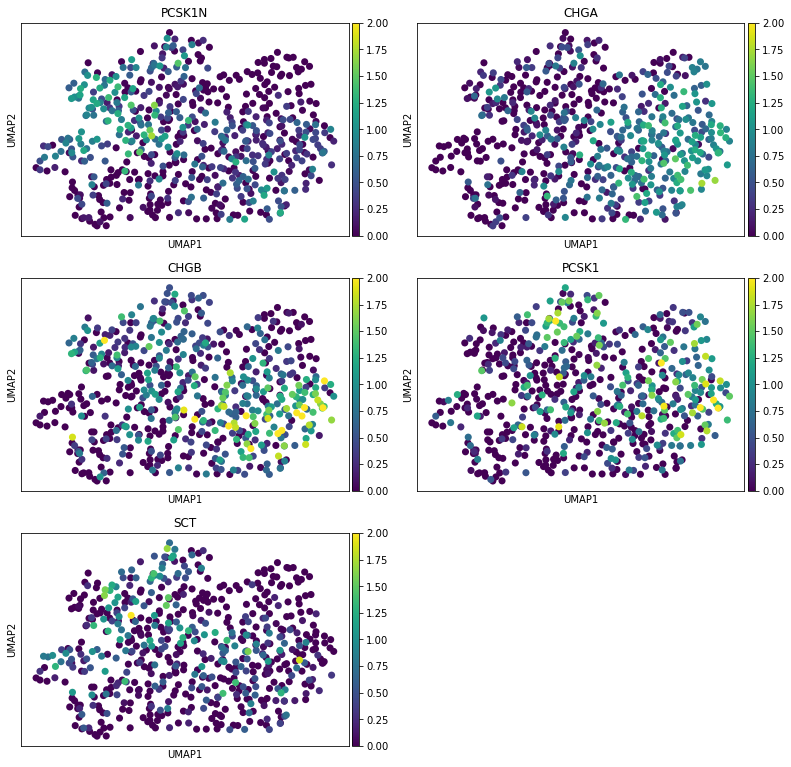

In [68]:
eec_cells = copy_dataset[copy_dataset.obs['annotation'].isin(hormone_dict['SCT'][0])]
sc_data_subset = eec_downstream_analysis(eec_cells, True, mitochondrial_genes_list)


# Keep only expressed genes and normalize subsets for each annotation

In [69]:
copy_dataset2 = copy_dataset.copy()
annotation_normal_subset_dict = get_normalized_subsets_dict_for_annotations(copy_dataset2, top_annotations_list)

Removing unexpressed genes for annotation: K cells (GIP+)
#Genes before:  33525 #Genes after:  14946 

Removing unexpressed genes for annotation: I cells (CCK+)
#Genes before:  33525 #Genes after:  16686 

Removing unexpressed genes for annotation: L cells (PYY+)
#Genes before:  33525 #Genes after:  12708 

Removing unexpressed genes for annotation: N cells (NTS+)
#Genes before:  33525 #Genes after:  11600 

Removing unexpressed genes for annotation: D cells (SST+)
#Genes before:  33525 #Genes after:  15488 

Removing unexpressed genes for annotation: EC cells (TAC1+)
#Genes before:  33525 #Genes after:  17764 



In [70]:
hormone_of_interest = 'SCT'

# Get correlation matrix for each annotaion

In [71]:
annot_corrDF_dict = get_corr_for_hormone(annotation_normal_subset_dict, hormone_of_interest, 0.2)

# Correlation values of high expressing annotations

In [72]:
interesting_annotations_list = [hormone_of_interest + "_" + x for x in hormone_dict[hormone_of_interest][0]]
interesting_annotations_list2 = interesting_annotations_list.copy()
interesting_annotations_list2.remove("SCT_N cells (NTS+)")

In [73]:
df_merged = show_interesting_annot_corr(interesting_annotations_list, annot_corrDF_dict)

In [74]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
df_merged2 = df_merged.dropna(thresh=2)
#print(df_merged2)
list_common_correlated_genes = df_merged2.index.to_list()
#for x in list_common_correlated_genes:
#    print(x)

<AxesSubplot:>

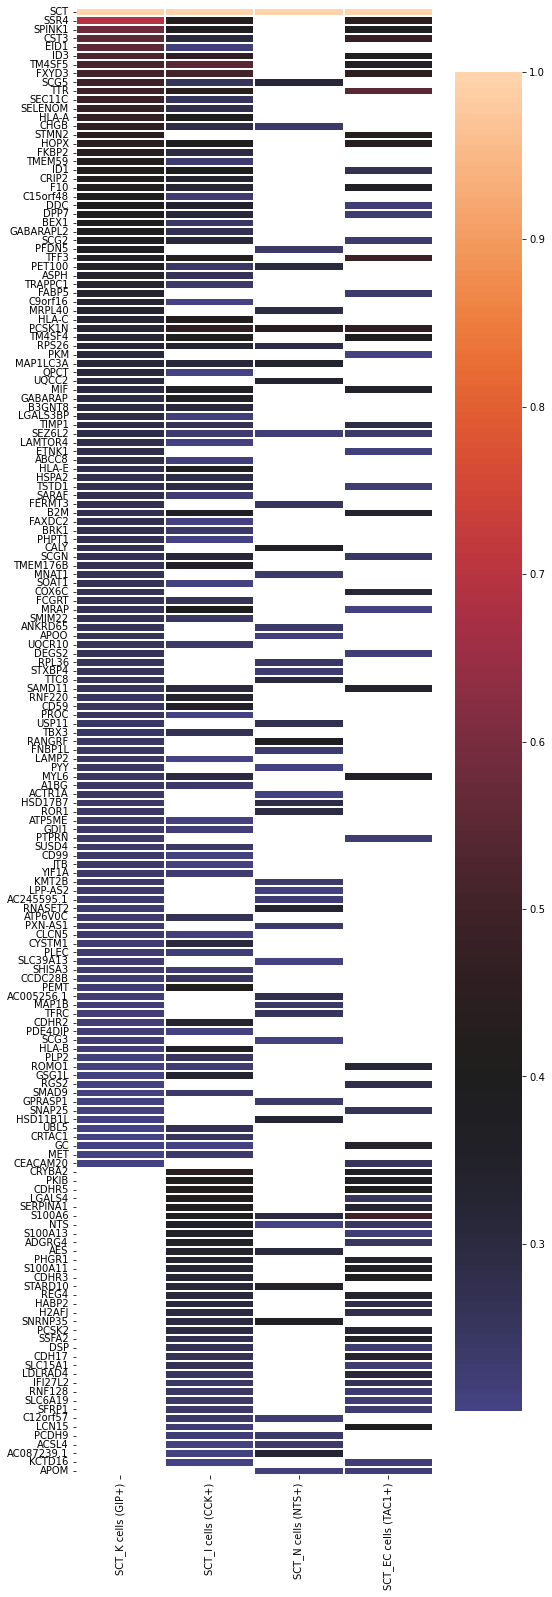

In [75]:
df_merged2 = df_merged2[df_merged2.index.isin(list_common_correlated_genes)]
fig, ax = plt.subplots(figsize=(8, 27))
sns.heatmap(df_merged2,
            xticklabels=df_merged2.columns,
            yticklabels=df_merged2.index, ax=ax, linewidths=0.01, center=0.4)

In [76]:
for x in list_common_correlated_genes:
    print(x)

SCT
SSR4
SPINK1
CST3
EID1
ID3
TM4SF5
FXYD3
SCG5
TTR
SEC11C
SELENOM
HLA-A
CHGB
STMN2
HOPX
FKBP2
TMEM59
ID1
CRIP2
F10
C15orf48
DDC
DPP7
BEX1
GABARAPL2
SCG2
PFDN5
TFF3
PET100
ASPH
TRAPPC1
FABP5
C9orf16
MRPL40
HLA-C
PCSK1N
TM4SF4
RPS26
PKM
MAP1LC3A
QPCT
UQCC2
MIF
GABARAP
B3GNT8
LGALS3BP
TIMP1
SEZ6L2
LAMTOR4
ETNK1
ABCC8
HLA-E
HSPA2
TSTD1
SARAF
FERMT3
B2M
FAXDC2
BRK1
PHPT1
CALY
SCGN
TMEM176B
MNAT1
SOAT1
COX6C
FCGRT
MRAP
SMIM22
ANKRD65
APOO
UQCR10
DEGS2
RPL36
STXBP4
TTC8
SAMD11
RNF220
CD59
PROC
USP11
TBX3
RANGRF
FNBP1L
LAMP2
PYY
MYL6
A1BG
ACTR1A
HSD17B7
ROR1
ATP5ME
GDI1
PTPRN
SUSD4
CD99
JTB
YIF1A
KMT2B
LPP-AS2
AC245595.1
RNASET2
ATP6V0C
PXN-AS1
CLCN5
CYSTM1
PLEC
SLC39A13
SHISA3
CCDC28B
PEMT
AC005256.1
MAP1B
TFRC
CDHR2
PDE4DIP
SCG3
HLA-B
PLP2
ROMO1
GSG1L
RGS2
SMAD9
GPRASP1
SNAP25
HSD11B1L
UBL5
CRTAC1
GC
MET
CEACAM20
CRYBA2
PKIB
CDHR5
LGALS4
SERPINA1
S100A6
NTS
S100A13
ADGRG4
AES
PHGR1
S100A11
CDHR3
STARD10
REG4
HABP2
H2AFJ
SNRNP35
PCSK2
SSFA2
DSP
CDH17
SLC15A1
LDLRAD4
IFI27L2
RNF128
SLC6A19
SF

<AxesSubplot:>

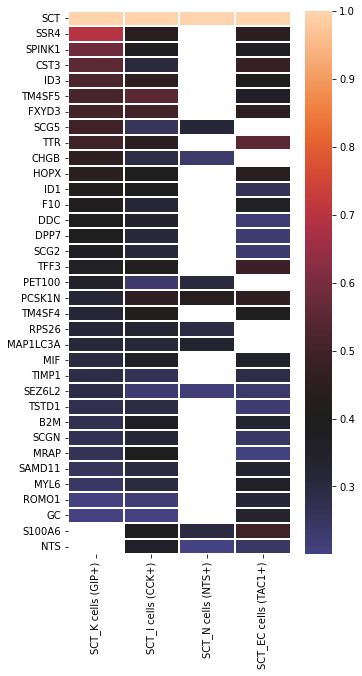

In [77]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
df_merged5 = df_merged.dropna(thresh=3)
#print(df_merged2)
list_common_correlated_genes3 = df_merged5.index.to_list()
df_merged5 = df_merged5[df_merged5.index.isin(list_common_correlated_genes3)]
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(df_merged5,
            xticklabels=df_merged5.columns,
            yticklabels=df_merged5.index, ax=ax, linewidths=0.01, center=0.4)

In [78]:
for gene in list_common_correlated_genes3:
    print(gene)

SCT
SSR4
SPINK1
CST3
ID3
TM4SF5
FXYD3
SCG5
TTR
CHGB
HOPX
ID1
F10
DDC
DPP7
SCG2
TFF3
PET100
PCSK1N
TM4SF4
RPS26
MAP1LC3A
MIF
TIMP1
SEZ6L2
TSTD1
B2M
SCGN
MRAP
SAMD11
MYL6
ROMO1
GC
S100A6
NTS


<AxesSubplot:>

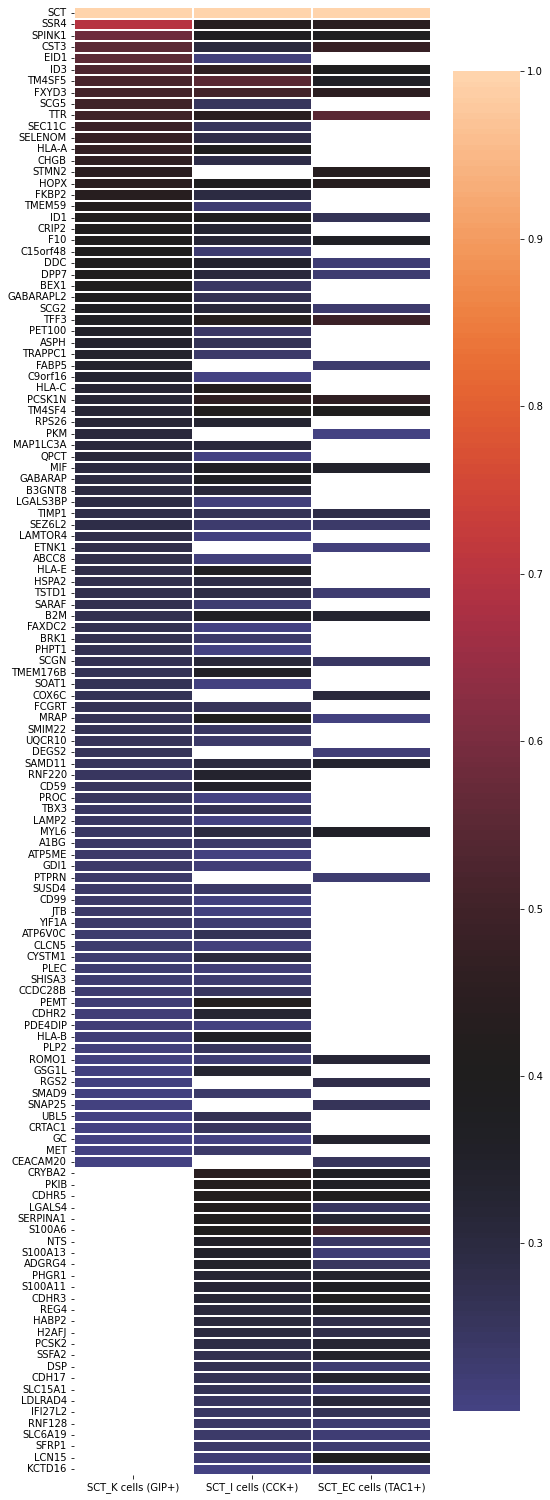

In [79]:
df_merged3 = show_interesting_annot_corr(interesting_annotations_list2, annot_corrDF_dict)
pd.set_option("display.max_rows", None, "display.max_columns", None)
df_merged4 = df_merged3.dropna(thresh=2)
#print(df_merged2)
list_common_correlated_genes2 = df_merged4.index.to_list()
df_merged4 = df_merged4[df_merged4.index.isin(list_common_correlated_genes2)]
fig, ax = plt.subplots(figsize=(8, 27))
sns.heatmap(df_merged4,
            xticklabels=df_merged4.columns,
            yticklabels=df_merged4.index, ax=ax, linewidths=0.01, center=0.4)

In [80]:
for x in df_merged4.index:
    print(x)

SCT
SSR4
SPINK1
CST3
EID1
ID3
TM4SF5
FXYD3
SCG5
TTR
SEC11C
SELENOM
HLA-A
CHGB
STMN2
HOPX
FKBP2
TMEM59
ID1
CRIP2
F10
C15orf48
DDC
DPP7
BEX1
GABARAPL2
SCG2
TFF3
PET100
ASPH
TRAPPC1
FABP5
C9orf16
HLA-C
PCSK1N
TM4SF4
RPS26
PKM
MAP1LC3A
QPCT
MIF
GABARAP
B3GNT8
LGALS3BP
TIMP1
SEZ6L2
LAMTOR4
ETNK1
ABCC8
HLA-E
HSPA2
TSTD1
SARAF
B2M
FAXDC2
BRK1
PHPT1
SCGN
TMEM176B
SOAT1
COX6C
FCGRT
MRAP
SMIM22
UQCR10
DEGS2
SAMD11
RNF220
CD59
PROC
TBX3
LAMP2
MYL6
A1BG
ATP5ME
GDI1
PTPRN
SUSD4
CD99
JTB
YIF1A
ATP6V0C
CLCN5
CYSTM1
PLEC
SHISA3
CCDC28B
PEMT
CDHR2
PDE4DIP
HLA-B
PLP2
ROMO1
GSG1L
RGS2
SMAD9
SNAP25
UBL5
CRTAC1
GC
MET
CEACAM20
CRYBA2
PKIB
CDHR5
LGALS4
SERPINA1
S100A6
NTS
S100A13
ADGRG4
PHGR1
S100A11
CDHR3
REG4
HABP2
H2AFJ
PCSK2
SSFA2
DSP
CDH17
SLC15A1
LDLRAD4
IFI27L2
RNF128
SLC6A19
SFRP1
LCN15
KCTD16


In [81]:
top_eec = copy_dataset[copy_dataset.obs['annotation'].isin(hormone_dict['SCT'][0])]
top_eec_copy = top_eec.copy()
top_eec = remove_genes_not_expressed(top_eec)
top_eec = norm_and_filter(top_eec)

Removing unexpressed genes for annotation: 
#Genes before:  33525 #Genes after:  19483 



In [82]:
top_eec_cor = top_eec.to_df().corr()
top_eec_sct = top_eec_cor[hormone_of_interest].to_frame()

In [83]:
top_eec_test = top_eec_sct[(top_eec_sct[top_eec_sct.columns] >= 0.3).all(axis=1)]
top_eec_test = top_eec_test.sort_values(by=hormone_of_interest, ascending=False)

<AxesSubplot:>

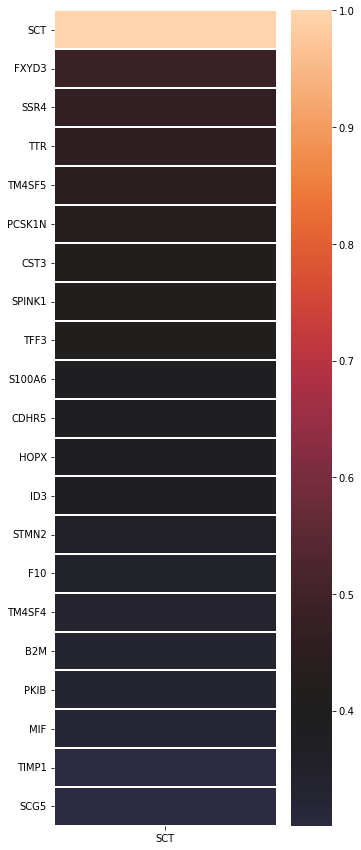

In [84]:
fig, ax = plt.subplots(figsize=(5, 15))
sns.heatmap(top_eec_test,
            xticklabels=top_eec_test.columns,
            yticklabels=top_eec_test.index, ax=ax, linewidths=0.01, center=0.4)

In [85]:
for x in top_eec_test.index.tolist():
    print(x)

SCT
FXYD3
SSR4
TTR
TM4SF5
PCSK1N
CST3
SPINK1
TFF3
S100A6
CDHR5
HOPX
ID3
STMN2
F10
TM4SF4
B2M
PKIB
MIF
TIMP1
SCG5


# Differential Gene Correlation Analysis 

Read results of DGCA 

In [86]:
#dgca_results = read_dgca_results('SCT')
#dgca_results

Gene1 Gene2  enteroendocrine_cor  enteroendocrine_pVal  \
1                RBP2   SCT            -0.344487          0.000000e+00   
2              SLC7A7   SCT            -0.311425          0.000000e+00   
3               APOA4   SCT            -0.294242          0.000000e+00   
4                APOB   SCT            -0.302557          0.000000e+00   
5               APOA1   SCT            -0.222244          7.017320e-10   
6                CD68   SCT            -0.293392          2.220446e-16   
7               FABP2   SCT            -0.328378          0.000000e+00   
8               APOC3   SCT            -0.280843          3.996803e-15   
9                CTSA   SCT            -0.244657          1.002620e-11   
10               MTTP   SCT            -0.281958          3.108624e-15   
11              ENPP7   SCT            -0.175027          1.349900e-06   
12             MAMDC4   SCT            -0.257541          7.136514e-13   
13            SELENOP   SCT            -0.269380          5.506706e-14   
14               FN3K   SCT            -0.216234          2.036867e-09   
15               MYL9   SCT            -0.237400          4.162004e-11   
16                MAF   SCT            -0.222155          7.129870e-10   
17             SLC2A2   SCT            -0.232403          1.079909e-10   
18              FABP1   SCT            -0.263299          2.087219e-13   
19              MUC13   SCT            -0.205321          1.304222e-08   
20             GOLT1A   SCT            -0.219444          1.157318e-09   
21              BTNL3   SCT            -0.275404          1.421085e-14   
22              ACSL5   SCT            -0.250255          3.238521e-12   
23              FBXO2   SCT            -0.205270          1.315257e-08   
24            SULT2A1   SCT            -0.215207          2.435860e-09   
25              GSTA1   SCT            -0.202566          2.051588e-08   
26            S100A14   SCT            -0.231857          1.196927e-10   
27           C19orf33   SCT            -0.255082          1.195488e-12   
28            C3orf85   SCT            -0.246085          7.534862e-12   
29               TFF3   SCT             0.352880          0.000000e+00   
30            SLC5A12   SCT            -0.227143          2.877747e-10   
31             LPGAT1   SCT            -0.184147          3.612231e-07   
32                FTL   SCT            -0.183470          3.993114e-07   
33               FBP1   SCT            -0.257748          6.830092e-13   
34               NEU1   SCT            -0.173342          1.709682e-06   
35              CIDEB   SCT            -0.223675          5.420175e-10   
36           C17orf99   SCT            -0.192572          1.006834e-07   
37              SMLR1   SCT            -0.177546          9.442210e-07   
38            CREB3L3   SCT            -0.226820          3.053389e-10   
39              FABP5   SCT             0.226037          3.525367e-10   
40               IL32   SCT            -0.256036          9.792167e-13   
41              EFNA1   SCT            -0.249110          4.090062e-12   
42               ACE2   SCT            -0.194397          7.576953e-08   
43             ANXA13   SCT            -0.190707          1.342631e-07   
44               CTSH   SCT            -0.261232          3.255174e-13   
45             SPINK1   SCT             0.343200          0.000000e+00   
46              DEFB1   SCT            -0.196176          5.727462e-08   
47                KHK   SCT            -0.225469          3.911571e-10   
48             ERICH4   SCT            -0.205567          1.252131e-08   
49                OAT   SCT            -0.291790          4.440892e-16   
50              BTNL8   SCT            -0.233374          8.988144e-11   
51           C1QTNF12   SCT            -0.224487          4.677234e-10   
52             TMEM37   SCT            -0.260954          3.455014e-13   
53               LGMN   SCT            -0.184502          3.426933e-07   
54              HMOX

In [87]:
#top_correlations = get_top_correlations(dgca_results,'-', 100)
#top_correlations

Gene1 Gene2  enteroendocrine_cor  enteroendocrine_pVal  \
1          RBP2   SCT            -0.344487          0.000000e+00   
2        SLC7A7   SCT            -0.311425          0.000000e+00   
3         APOA4   SCT            -0.294242          0.000000e+00   
4          APOB   SCT            -0.302557          0.000000e+00   
5         APOA1   SCT            -0.222244          7.017320e-10   
6          CD68   SCT            -0.293392          2.220446e-16   
7         FABP2   SCT            -0.328378          0.000000e+00   
8         APOC3   SCT            -0.280843          3.996803e-15   
9          CTSA   SCT            -0.244657          1.002620e-11   
10         MTTP   SCT            -0.281958          3.108624e-15   
11        ENPP7   SCT            -0.175027          1.349900e-06   
12       MAMDC4   SCT            -0.257541          7.136514e-13   
13      SELENOP   SCT            -0.269380          5.506706e-14   
14         FN3K   SCT            -0.216234          2.036867e-09   
15         MYL9   SCT            -0.237400          4.162004e-11   
16          MAF   SCT            -0.222155          7.129870e-10   
17       SLC2A2   SCT            -0.232403          1.079909e-10   
18        FABP1   SCT            -0.263299          2.087219e-13   
19        MUC13   SCT            -0.205321          1.304222e-08   
20       GOLT1A   SCT            -0.219444          1.157318e-09   
21        BTNL3   SCT            -0.275404          1.421085e-14   
22        ACSL5   SCT            -0.250255          3.238521e-12   
23        FBXO2   SCT            -0.205270          1.315257e-08   
24      SULT2A1   SCT            -0.215207          2.435860e-09   
25        GSTA1   SCT            -0.202566          2.051588e-08   
26      S100A14   SCT            -0.231857          1.196927e-10   
27     C19orf33   SCT            -0.255082          1.195488e-12   
28      C3orf85   SCT            -0.246085          7.534862e-12   
30      SLC5A12   SCT            -0.227143          2.877747e-10   
31       LPGAT1   SCT            -0.184147          3.612231e-07   
32          FTL   SCT            -0.183470          3.993114e-07   
33         FBP1   SCT            -0.257748          6.830092e-13   
34         NEU1   SCT            -0.173342          1.709682e-06   
35        CIDEB   SCT            -0.223675          5.420175e-10   
36     C17orf99   SCT            -0.192572          1.006834e-07   
37        SMLR1   SCT            -0.177546          9.442210e-07   
38      CREB3L3   SCT            -0.226820          3.053389e-10   
40         IL32   SCT            -0.256036          9.792167e-13   
41        EFNA1   SCT            -0.249110          4.090062e-12   
42         ACE2   SCT            -0.194397          7.576953e-08   
43       ANXA13   SCT            -0.190707          1.342631e-07   
44         CTSH   SCT            -0.261232          3.255174e-13   
46        DEFB1   SCT            -0.196176          5.727462e-08   
47          KHK   SCT            -0.225469          3.911571e-10   
48       ERICH4   SCT            -0.205567          1.252131e-08   
49          OAT   SCT            -0.291790          4.440892e-16   
50        BTNL8   SCT            -0.233374          8.988144e-11   
51     C1QTNF12   SCT            -0.224487          4.677234e-10   
52       TMEM37   SCT            -0.260954          3.455014e-13   
53         LGMN   SCT            -0.184502          3.426933e-07   
54        HMOX1   SCT            -0.230679          1.492888e-10   
55        MXRA8   SCT            -0.175994          1.177553e-06   
56         GLRX   SCT            -0.217371          1.668667e-09   
57   AC011139.1   SCT            -0.179302          7.337710e-07   
58       LGALS3   SCT            -0.275293          1.465494e-14   
59      SLC26A3   SCT            -0.209709          6.256113e-09   
60      SLC40A1   SCT            -0.226638          3.157479e-10   
61          GNS   SCT            -0.181847          5.068501e-07  

In [88]:
#top_correlated_genes_list = show_top_correlated_genes(top_correlations)
#for gene in top_correlated_genes_list:
#    print(gene)

['RBP2', 'SLC7A7', 'APOA4', 'APOB', 'APOA1', 'CD68', 'FABP2', 'APOC3', 'CTSA', 'MTTP', 'ENPP7', 'MAMDC4', 'SELENOP', 'FN3K', 'MYL9', 'MAF', 'SLC2A2', 'FABP1', 'MUC13', 'GOLT1A', 'BTNL3', 'ACSL5', 'FBXO2', 'SULT2A1', 'GSTA1', 'S100A14', 'C19orf33', 'C3orf85', 'SLC5A12', 'LPGAT1', 'FTL', 'FBP1', 'NEU1', 'CIDEB', 'C17orf99', 'SMLR1', 'CREB3L3', 'IL32', 'EFNA1', 'ACE2', 'ANXA13', 'CTSH', 'DEFB1', 'KHK', 'ERICH4', 'OAT', 'BTNL8', 'C1QTNF12', 'TMEM37', 'LGMN', 'HMOX1', 'MXRA8', 'GLRX', 'AC011139.1', 'LGALS3', 'SLC26A3', 'SLC40A1', 'GNS', 'PLIN2', 'MUC17', 'XPNPEP2', 'DAB2', 'G0S2', 'ANXA4', 'TM4SF20', 'SAT1', 'AGT', 'RHOF', 'CYP2W1', 'MELTF', 'FOLH1', 'FTH1', 'AFP', 'DAB1', 'IL18', 'SLC46A3', 'TMEM92', 'PEPD', 'MST1', 'DGAT1', 'COL6A1', 'CPVL', 'RENBP', 'MSLN', 'CHP2', 'ESPN', 'HSD17B14', 'PNCK', 'METTL7B', 'TGM2', 'NR1H4', 'CDK2AP2', 'ASAH1', 'ANPEP', 'ASS1', 'PLLP', 'MEP1A', 'AL121974.1', 'GRINA', 'GK']
RBP2
SLC7A7
APOA4
APOB
APOA1
CD68
FABP2
APOC3
CTSA
MTTP
ENPP7
MAMDC4
SELENOP
FN3K
MYL9
